# Aggregate + plot HMM results across subjects / ROIs
**[Contributors: James Antony](#contributions)**   

### Goal of this script
 1. Using output from Event_HMM-ROI.ipynb, this script will aggregate, calculate, & plot results + brain maps across subjects / ROIs

### Steps of this script, in two parallel tracks
 1. Load HMM transition + neural data (choosing ROIs vs. parcels, using 'roiparcel')
 2. When plotting ROIs, ...
    - plot correlations for (binary) possession boundaries vs. HMM state transitions (Fig 3B, right)
    - plot mean surprise / game vs. best-fitting number of states and true vs null distributions (Fig 3C)
    - plot HMM state transition agreement for each possession vs various metrics @ possession boundaries (Fig 3D)
    - at the very end of the script, plot ROIs themselves (Fig 3A for HMM ROIs / Fig 5A for GLM ROIs)
 3. When plotting parcels, ...
    - print output into tables (Table S1)
    - plot surface maps of values for each parcel (Fig S3)
 4. (Either track) Other univariate ROI activity aligned to possession boundaries, like VTA, plotted in Fig S8
 5. (Either track) Correlations between game-level enjoyment and surprise, plotted in Fig S4A

In [1]:
ipynby=1 #use python notebook or not
subs=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']#
ROIs = ['V1','vmPFC','precun']
roiparcel=2 #run specific ROIs or parcels? 1=custom ROIs,2=parcel ROIs
n_trunc=3 # Number of volumes to trim/truncate
boundtype=0 #1 = if we just want to look at moments when winning team flips
pltb=0 #plot on brain or no
hrshiftval=5 # TRs to shift for HRF
filtcutoff=140 #high-pass filter (in s)
smoothf=7 # +/- smoothing window
splitm=1 #use split_merge=True on HMM training
smoothshift=0 #shift from 0? (unused)
exportR=1 #export to R or no
ttps=smoothf*2+1 #time points pooling for HMM agreement
nanend=0 #1=nan out final possession b/c of timing? set to 0
fact4y=1 #use 4-factor model (1) or expert (0)?

In [2]:
import numpy as np
import numpy.matlib
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import csv
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.datasets import load_mni152_template
import scipy.stats as stats
from nilearn.masking import intersect_masks
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from scipy import stats, signal
from scipy.stats import norm, zscore, pearsonr
from sklearn.manifold import MDS, TSNE
import nibabel as nib
import scipy.io
from brainiak import image, io
import statsmodels.stats.multitest as smm
from isc_standalone import isc
#from brainiak.isc import isc
import pandas as pd 
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
import seaborn as sns 
if ipynby:
    %autosave 5
    %matplotlib inline
    sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 5 seconds


In [3]:
#import presets and a # of important variables
from ss_utils import ss_dir, ss_bids_dir, ss_TR, ss_hrf_lag, run_names, n_runs
from ss_utils import load_ss_epi_data, load_ss_mask, mask_data, load_data
firstlevel_dir=ss_bids_dir+'derivatives/firstlevel/'
results_path=ss_bids_dir+'derivatives/secondlevel/'
dir_out = results_path + 'HMM/'
rdir=ss_dir+'RStuff/'
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    print('Dir %s created ' % dir_out)
#import data from .mats
analysis_dir=ss_dir+'analysis/'
if fact4y==0: #use Ken Pom win probability values
    mat_fname=analysis_dir+'gamebinmeans0.mat' 
    mat_fname2=analysis_dir+'d_event_mat0.mat' 
elif fact4y==1: #use 4-factor model (used in paper)
    mat_fname=analysis_dir+'gamebinmeans1.mat' 
    mat_fname2=analysis_dir+'d_event_mat1.mat' 

mat_contents = scipy.io.loadmat(mat_fname)
gamebinsurmean = mat_contents['gamebinsurmean'] # mean surprise / game
gamebinsurstdev = mat_contents['gamebinsurstdev'] # mean surprise / game
gamebinsurtotal = mat_contents['gamebinsurtotal'] # total surprise / game
gamebinBCsurtotal = mat_contents['gamebinBCsurtotal'] # total surprise / game
gamebinBICsurtotal = mat_contents['gamebinBICsurtotal'] # total surprise / game
gamebindurmean = mat_contents['gamebindurmean'] # duration (in minutes) / game
gamebinBCsurmean=np.divide(gamebinBCsurtotal,gamebindurmean)*60
gamebinBICsurmean=np.divide(gamebinBICsurtotal,gamebindurmean)*60
game_poss = mat_contents['game_poss'] # # possessions / game
tot_mot = mat_contents['tot_mot'] # total motion / game
mat_contents = scipy.io.loadmat(mat_fname2)
event_mat = mat_contents['event_mat'] 
d_mat_hrf = mat_contents['d_mat_hrf'] #design matrix for GLM
p_fl = mat_contents['p_fl'] #important matrix containing information about each possession
mat_fname=analysis_dir+'evSeg.mat'
mat_contents = scipy.io.loadmat(mat_fname)
evsegs = mat_contents['evs'] # event segmentation agreement / possession
mat_fname=analysis_dir+'recall_vars.mat'
mat_contents = scipy.io.loadmat(mat_fname)
possm = mat_contents['possm'] # memory performance / possession
mat_fname=analysis_dir+'PACPoss.mat' #pupil area change data
mat_contents = scipy.io.loadmat(mat_fname) 
PACPoss = mat_contents['PACPoss'] 
PACPoss_pre = mat_contents['PACPoss_pre'] 
#plotting things
colpal=sns.color_palette() #colors for seaborn plots at the bottom
crange=.2 #for plotting
#basic global variables
nS=len(subs)
if roiparcel==1:
    nR=len(ROIs)
elif roiparcel==2:
    nR=48 #hard-coded # of bilateral cortical parcels in Harvard-Oxford atlas
nPoss=p_fl.shape[0]
nTR=event_mat.shape[0]
catls=['bestk_smooth','bestk_sur_smooth']
cats=len(catls)
ses='ses-01'
tngs=9
ent_col,sur_col=16,5
#use these for univariate alignment with ROIs
surprise_unsigned_ent=d_mat_hrf[:,ent_col]
surprise_unsigned=d_mat_hrf[:,sur_col]    
surprise_unsigned_bc=(np.absolute(surprise_unsigned_ent-surprise_unsigned))/2   
surprise_unsigned_bic=(surprise_unsigned_ent+surprise_unsigned)/2

#load in data by subject
signed_cols=16 #column of signed data
enjoy_all=np.zeros((nS,tngs))
for sub in range(nS): #load in enjoyment values and signed information
    nonfmri_dir=ss_dir+'data/nonfmri/%s/' %(sub+1)
    mat_fname=nonfmri_dir+'g_o_m2.mat'
    mat_contents = scipy.io.loadmat(mat_fname)
    enjoy_g_o = mat_contents['enjoy_g_o'] 
    enjoy_all[sub,:]=enjoy_g_o #enjoyment, re-ordered by game number, not trial number
    mat_fname=nonfmri_dir+'confounds_hrf2_%s.mat' %hrshiftval
    mat_contents = scipy.io.loadmat(mat_fname)
    signed_event = mat_contents['signed_event'] #movie end TRs
    if sub==0:
        signed_all= np.zeros((nS,signed_event.shape[0]))
        surprise_signed=np.zeros((nS,signed_event.shape[0]))
    signed_all[sub,:]=signed_event[:,0]#subject pref
    #multiply subject-specific vector by home team signed surprise
    surprise_signed[sub,:]=np.multiply(event_mat[:,signed_cols],signed_event[:,0].T)

print('# possessions=%s' %nPoss)
print('Mean enjoyment / game:')
print(np.mean(enjoy_all,axis=0))
print('Mean surprise / game:')
print(gamebinsurmean)
print('Duration / game:')
print(gamebindurmean)

# possessions=157
Mean enjoyment / game:
[5.4  5.35 5.7  5.25 5.3  5.05 2.75 4.2  2.9 ]
Mean surprise / game:
[[ 8.54992428  9.33830032  9.42546054  7.10286354  5.08754724 13.92356737
   0.16490789  3.59741066  0.03763708]]
Duration / game:
[[373.5732     410.89723333 441.03333333 412.7601     375.96666667
  328.73333333 345.3        452.4        353.2984    ]]


In [4]:
#find avg brain mask across subjects!
mask_imgs=[]
for s in range(nS): 
    subj=subs[s]
    if len(str(subj))==1:
        sub ='sub-0'+str(subj)
    else:
        sub ='sub-'+str(subj)
    mask_fold = ss_bids_dir + 'derivatives/firstlevel/%s/masks/' % sub
    mask_name = mask_fold + '%s_%s_brain.nii.gz' % (sub, ses)
    mask_imgs.append(mask_name)
    brain_mask1 = io.load_boolean_mask(mask_name)

avg_mask=intersect_masks(mask_imgs, threshold=0.5, connected=True)# intersect    
avg_mask_name = results_path + 'avg_brain_mask.nii.gz'
print(avg_mask_name)
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
print(affine_mat)
hdr = avg_mask.header  # Get a handle for the .nii file's header
hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
nib.save(avg_mask, avg_mask_name)#save x-sub avg mask
print(avg_mask.shape)
brain_mask = io.load_boolean_mask(avg_mask_name)# Load the brain mask
coords = np.where(brain_mask)# Get the list of nonzero voxel coordinates
brain_nii = nib.load(avg_mask_name)# Load the brain nii image
print(brain_nii.shape)

/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/secondlevel/avg_brain_mask.nii.gz
[[   3.    0.    0.  -90.]
 [   0.    3.    0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
(61, 73, 61)
(61, 73, 61)


In [5]:
#load mPFC / other ROI to check which parcels overlap
if roiparcel==2:
    all_task_names = ['view_gb1']
    ROIs0 = ['precun']#'vmPFC','precun'
    nR0=len(ROIs0)
    from brainiak import image, io
    def get_file_names(data_dir_, task_name_,n_trunc_,hrshiftval_,filtcutoff_, verbose = False):
        c_ = 0 
        fnames_ = []
        for s in range(1):#nS 
            subj=subs[s]
            if len(str(subj))==1:
                sub ='sub-0'+str(subj)
            else:
                sub ='sub-'+str(subj)
            print(sub)
            fname = os.path.join(
                data_dir_, '%s/%s_task-%s_trim%d_%s_%s.nii.gz' % (sub, sub, task_name_,n_trunc_,hrshiftval_,filtcutoff_))
            print(fname)
            if os.path.exists(fname):
                fnames_.append(fname)
                if verbose: 
                    print(fname)
                c_+= 1
        return fnames_

    def load_roi_data(roi_name): 
        roi_masker = all_roi_masker[roi_name] # Pick a roi masker
        bold_roi = {task_name:[] for i, task_name in enumerate(all_task_names)} # Preallocate 
        for task_name in all_task_names: # Gather data
            for subj_id in range(1):#nS
                nii_t_s = nib.load(fnames[task_name][subj_id])
                bold_roi[task_name].append(roi_masker.fit_transform(nii_t_s))
            bold_roi[task_name] = np.transpose(np.array(bold_roi[task_name]), [1,2,0])
        return bold_roi

    fnames = {}
    images = {}
    masked_images = {}
    bold = {}
    n_subjs = {}
    for task_name in all_task_names: 
        fnames[task_name] = get_file_names(firstlevel_dir, task_name,n_trunc,hrshiftval,filtcutoff)
        images[task_name] = io.load_images(fnames[task_name]) 
        masked_images[task_name] = image.mask_images(images[task_name], brain_mask) 
        bold[task_name] = image.MaskedMultiSubjectData.from_masked_images(
            masked_images[task_name], len(fnames[task_name]))
        bold[task_name][np.isnan(bold[task_name])] = 0

    sub = 'sub-01' # sample subject for ROI
    all_roi_nii = {}
    all_roi_masker = {}
    for mask_counter in range(nR0):
        out_dir= ss_bids_dir + 'derivatives/firstlevel/%s/' % sub
        roi_name = ROIs0[mask_counter]
        roi_fn = out_dir + 'masks/%s_%s.nii.gz' % (sub,ROIs0[mask_counter])
        roi_nii = nib.load(roi_fn)
        all_roi_nii[roi_name] = roi_nii
        all_roi_masker[roi_name] = NiftiMasker(mask_img=roi_nii)

    threshold= 0.1
    for roi in range(nR0):#
        roi_graph=np.zeros(brain_nii.shape)
        roi_name=ROIs0[roi]
        indd=all_roi_nii[roi_name].dataobj[:,:,:] #convert to np array
        fill2 = indd==1
        roi_coords=np.logical_and(brain_mask>0,fill2>0)
        roi_graph[roi_coords]=1

sub-01
/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-01/sub-01_task-view_gb1_trim3_5_140.nii.gz


number of bilateral parcels:	 48
1-Left Frontal Pole
2-Left Insular Cortex
3-Left Superior Frontal Gyrus
4-Left Middle Frontal Gyrus
5-Left Inferior Frontal Gyrus, pars triangularis
6-Left Inferior Frontal Gyrus, pars opercularis
7-Left Precentral Gyrus
8-Left Temporal Pole
9-Left Superior Temporal Gyrus, anterior division
10-Left Superior Temporal Gyrus, posterior division
11-Left Middle Temporal Gyrus, anterior division
12-Left Middle Temporal Gyrus, posterior division
13-Left Middle Temporal Gyrus, temporooccipital part
14-Left Inferior Temporal Gyrus, anterior division
15-Left Inferior Temporal Gyrus, posterior division
16-Left Inferior Temporal Gyrus, temporooccipital part
17-Left Postcentral Gyrus
18-Left Superior Parietal Lobule
19-Left Supramarginal Gyrus, anterior division
20-Left Supramarginal Gyrus, posterior division
21-Left Angular Gyrus
22-Left Lateral Occipital Cortex, superior division
23-Left Lateral Occipital Cortex, inferior division
24-Left Intracalcarine Cortex
25-

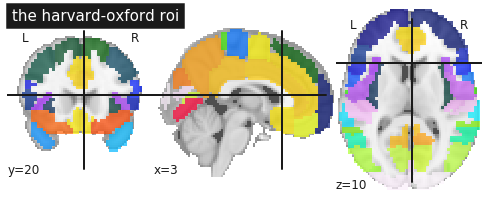

In [6]:
# load parcels!
from nilearn import image
from nilearn.image.image import mean_img
from nilearn.image import resample_to_img
i=np.eye(3)*3 #identity matrix to resample to 3 mm isometric
template0 = load_mni152_template() # load MNI template
template =image.resample_img(template0, target_affine=i,interpolation='nearest') #resample
if roiparcel==2:
    atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', symmetric_split=True)
    atlas.maps=image.resample_img(atlas.maps, target_affine=i,interpolation='nearest') #downsample to 3mm
    plotting.plot_roi(atlas.maps, title='the harvard-oxford roi',cut_coords=[3, 20, 10]) #quick parcels plot
    nP = len(atlas.labels)-1 # rm background region 
    print('number of bilateral parcels:\t {}'.format(np.int(nP/2)))
    masker_ho = NiftiLabelsMasker(labels_img=atlas.maps) # parcel labels
    index=masker_ho.labels_img.dataobj
    ROIs=atlas.labels #rois
    #print(ROIs)
    ROIs[51]='Left Juxtapositional Lobule Cortex' #shorten parcel 51/52 labels
    ROIs[52]='Right Juxtapositional Lobule Cortex'
    for r in range(1,nR+1):
        print('%s-%s' %(r,ROIs[(r-1)*2+1])) #print all 'left' parcels, which have been combined w/ right counterparts

In [7]:
#find % overlap w/ ROI
if roiparcel==2:
    qq0=roi_graph==1
    frac=np.zeros((nR*2))
    frac2=np.zeros((nR*2))
    for r in range(nR*2): #nR
        atlas2 = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', symmetric_split=True)
        atlas2.maps=image.resample_img(atlas2.maps, target_affine=i,interpolation='nearest')         
        qq=atlas2.maps.dataobj==r+1 #qq=atlas2.maps.dataobj==r*2+1
        qq2=np.logical_and(qq==1,qq0==1)
        frac[r]=np.sum(qq2)/np.sum(qq0)
        frac2[r]=np.sum(qq2)/np.sum(qq)
        #qq=atlas2.maps.dataobj!=r*2+1
        #atlas2.maps.dataobj[qq]=0
        #plotting.plot_roi(atlas2.maps, title='the harvard-oxford roi')
    print(frac)
    print(frac2)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.54444444 0.45555556 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.         0.         0.         0.         0.

In [8]:
#other functions for running below!
#function for running mean
def running_mean(x, N):
    rm=np.zeros((x.shape[0]))
    for i in range(0,len(x)):
        if i<N:
            rm[i]=np.mean(x[0:i+N])
        elif i>len(x)-1-N:
            rm[i]=np.mean(x[i-N:len(x)-1])
        else:
            rm[i]=np.mean(x[i-N:i+N])
    return rm

#function for violin plot
def vplot(true,dist,yl,rankd,sps,sp,y):
    if sps>1:
        ax[sp].violinplot(dist, showextrema=False)
        ax[sp].scatter(1,true)
        ax[sp].xaxis.set_visible(False)
    else:
        ax.violinplot(dist, showextrema=False)
        ax.scatter(1,true)
        ax.xaxis.set_visible(False)
        ax.set_yticks(np.arange(-y,y+0.01,y/2))

#function for surface plot of medial+lateral views (bilateral combined in analysis, so only plotting right)
def plotsurface(x,threshold,psz,fign):
    #vmaxspesh=0.42
    texture = surface.vol_to_surf(x, fsaverage.pial_right)# make "texture"
    f, ax = plt.subplots(1,1,figsize=(psz*3/4,psz*3/5),subplot_kw={'projection': '3d'})
    surf_map = plotting.plot_surf_stat_map(fsaverage.infl_right, texture,hemi='right', view='medial', 
        threshold=threshold,cmap='jet',colorbar=False,bg_map=fsaverage.sulc_right,axes=ax)# ,vmax=vmaxspesh,
    f.tight_layout()
    f.savefig(fign+'rm-%s.svg' %(n_trunc))
    f, ax = plt.subplots(1,1,figsize=(psz*3/4,psz*3/5),subplot_kw={'projection': '3d'})
    surf_map = plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right', view='lateral', 
        threshold=threshold,cmap='jet',colorbar=False,bg_map=fsaverage.sulc_right,axes=ax)# ,vmax=vmaxspesh,colorbar=True,
    f.tight_layout()
    f.savefig(fign+'rl-%s.svg' %(n_trunc))
    return x

#function for partial correlations (https://gist.github.com/fabianp/9396204419c7b638d38f)
from scipy import stats, linalg 
def partial_corr(C):
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

In [15]:
# aggregate variables from rois and different games
best_k_xsub=np.zeros((tngs,nR,nS)) #preset variables
best_k_subs_tot=np.zeros((tngs,nR,nS))
mean_best_k_xsub=np.zeros((tngs,nR))
r_all=np.zeros((tngs,nR,cats))
rank_all=np.zeros((tngs,nR))
true_edges_cont_all2=np.zeros((nR,nTR))
true_edges_cont_sur_all2=np.zeros((nR,nTR))
true_edges_cont_smooth_all2=np.zeros((nR,nTR))
true_edges_cont_sur_smooth_all2=np.zeros((nR,nTR))
sum_bounds_smooth_all=np.zeros((nR,nTR))
bounds_subj_all=np.zeros((nR,nTR,nS))
bounds_subj_smooth_all=np.zeros((nR,nTR,nS))
possHMMagree_all=np.zeros((nPoss,nR))
possHMM_xsub_all=np.zeros((nS,nPoss,nR))
jj=0
univyet=0
for roitask in range(1,1+nR*tngs):
    game_num=int(np.ceil(roitask/nR)) #game # based on roitask
    roi_sel = (roitask-1)%nR #roi based on roitask
    if roiparcel==2: 
        roi_sel2=roi_sel*2 #method to combine left/right parcels
    all_task_names = ['view_gb%s' %game_num]
    task_name = 'view_gb%s' %game_num
    #load data
    if roiparcel==1:
        mat_fname=dir_out+'event_hmm129_out%s-%s-%s-%s-%s-%s-%s-%s-%s.mat' %(smoothf,smoothshift,n_trunc,hrshiftval,boundtype,task_name,ROIs[roi_sel],splitm,filtcutoff)
    elif roiparcel==2:
        mat_fname=dir_out+'event_hmm129_out%s-%s-%s-%s-%s-%s-%s-%s-%s.mat' %(smoothf,smoothshift,n_trunc,hrshiftval,boundtype,task_name,ROIs[roi_sel2+1],splitm,filtcutoff)

    mat_contents = scipy.io.loadmat(mat_fname)#28
    agree_r = mat_contents['agree_r'] 
    smooth_agree_r = mat_contents['smooth_agree_r'] 
    agree_sur_r = mat_contents['agree_sur_r']
    smooth_agree_sur_r = mat_contents['smooth_agree_sur_r']
    possHMMagree = mat_contents['possHMMagree']
    possHMM_xsub = mat_contents['possHMM_xsub']
    possHMMagree=possHMMagree[0,:]
    possHMM_xsub=possHMM_xsub[:,:]
    #possession level values
    ind=p_fl[:,0]==game_num #possessions for this particular game
    possHMMagree_all[ind,roi_sel]=possHMMagree.T    
    possHMM_xsub_all[:,ind,roi_sel]=possHMM_xsub
       
    #Put all of the boundary correlations together
    r_all[game_num-1,roi_sel,0]=smooth_agree_r
    r_all[game_num-1,roi_sel,1]=smooth_agree_sur_r
    
    within_across = mat_contents['within_across'] #load in within-across values
    rank_all[game_num-1,roi_sel]=stats.percentileofscore(within_across[:,1:].mean(0),within_across[:,0].mean(0))
    
    #load boundary data
    ind=event_mat[:,0]==game_num
    aa=mat_contents['true_edges_cont']
    true_edges_cont_all2[roi_sel,ind]=mat_contents['true_edges_cont']
    true_edges_cont_smooth_all2[roi_sel,ind]=mat_contents['true_edges_cont_smooth']
    true_edges_cont_sur_all2[roi_sel,ind]=mat_contents['true_edges_cont_sur']
    true_edges_cont_sur_smooth_all2[roi_sel,ind]=mat_contents['true_edges_cont_sur_smooth']
    sum_bounds_smooth_all[roi_sel,ind]=mat_contents['sum_bounds_smooth']
    fill=mat_contents['bounds_subj_smooth']
    bounds_subj_smooth_all[roi_sel,ind,:]=fill.T
    bounds_subj=mat_contents['bounds_subj']
    bounds_subj_all[roi_sel,ind,:]=bounds_subj.T
    
    events_subj = mat_contents['events_subj']
    best_k_subs=np.max(events_subj,axis=1)+1
    best_k_subs_tot[game_num-1,roi_sel,:]=best_k_subs #find total best-fitting K
    best_k_subs=np.divide(best_k_subs,gamebindurmean.T[game_num-1])*60 #find best K / minute
    best_k_xsub[game_num-1,roi_sel,:]=best_k_subs # Grab best K 
    mean_best_k_xsub[game_num-1,roi_sel]=np.mean(best_k_xsub[game_num-1,roi_sel,:]) # Grab mean best K 
    if roi_sel==0: #if 1st ROI, load in univariate data too
        HC_m=mat_contents['HC_m']
        HC_m=HC_m.T
        if univyet==0:
            HC_m_all=HC_m
        else:
            HC_m_all=np.hstack([HC_m_all,HC_m])
        VTA2_m=mat_contents['VTA2_m']
        VTA2_m=VTA2_m.T
        if univyet==0:
            VTA2_m_all=VTA2_m
        else:
            VTA2_m_all=np.hstack([VTA2_m_all,VTA2_m])
        NAcc_m=mat_contents['NAcc_m']
        NAcc_m=NAcc_m.T
        if univyet==0:
            NAcc_m_all=NAcc_m
            univyet=1
        else:
            NAcc_m_all=np.hstack([NAcc_m_all,NAcc_m])

FileNotFoundError: [Errno 2] No such file or directory: '/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/secondlevel/HMM/event_hmm129_out7-0-3-5-0-view_gb9-Left Precuneous Cortex-1-140.mat'

In [16]:
print(roitask) #print this in case there are missing files and we want to debug

415


In [137]:
#these are all the same, collapse (were loaded as above for simplicity)
true_edges_cont_all=true_edges_cont_all2[0,:]
true_edges_cont_sur_all=true_edges_cont_sur_all2[0,:]
true_edges_cont_smooth_all=true_edges_cont_smooth_all2[0,:]
true_edges_cont_sur_smooth_all=true_edges_cont_sur_smooth_all2[0,:]

#binarize any boundaries in pooling window w/ a max of 1
possHMM_xsub_all2=np.zeros((nS,nPoss,nR))
for sub in range(nS):
    for poss in range(nPoss):
        ind=possHMM_xsub_all[sub,poss,:]>0 #if there's > 0 boundaries, make it 1
        possHMM_xsub_all2[sub,poss,ind]=1

#if it is desired to nan out the final possession boundary because of edge effects 
# with the clip end. note, doing this does not qualitatively change results in the 
# analyses we performed. we've left nanend=0.
evw=np.diff(p_fl[:,0])
evw=np.hstack([evw,0])
evw[len(evw)-1]=1
evwhere=np.where(evw==0)
print(evwhere[0].shape)
evwherenot=np.where(evw==1)
print(evwherenot)
if nanend: 
    possHMM_xsub_all[:,evwherenot,:]=float('nan')
    possHMMagree_all[evwherenot,:]=float('nan')

(148,)
(array([ 14,  32,  52,  75,  91, 102, 115, 141, 156]),)


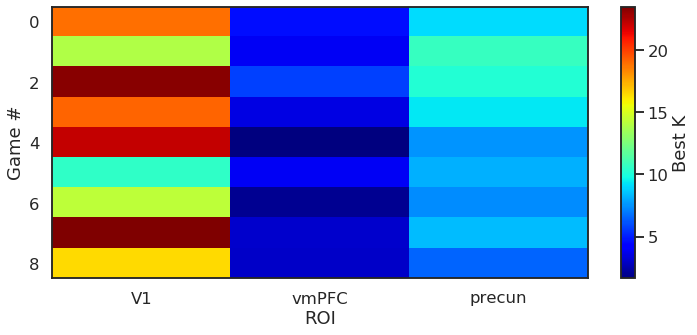

In [138]:
#plot mean best K for all games and all ROIs
if ipynby: 
    f, ax = plt.subplots(1,1, figsize=(12,5))
    im=plt.imshow(np.mean(best_k_subs_tot,axis=2),cmap="jet",origin="upper",interpolation="none",aspect="auto")
    ax.set_xlabel('ROI')
    ax.set_xticks(np.arange(nR))
    ax.set_xticklabels(ROIs)
    ax.set_ylabel('Game #')
    cbar=f.colorbar(im, orientation='vertical')
    cbar.set_label('Best K', rotation=90)

In [122]:
#print some basics about these best K values
mean_states_persub=np.mean(best_k_subs_tot,axis=2)
grand_mean_states=np.mean(mean_states_persub,axis=0)
print('ROI names: %s' %ROIs)
print('Mean states across all games: %s' %grand_mean_states)
print('Mean state transitions across all games: %s' %(grand_mean_states-1))

ROI names: ['V1', 'vmPFC', 'precun']
Mean states across all games: [18.03888889  3.52777778  8.62777778]
Mean state transitions across all games: [17.03888889  2.52777778  7.62777778]


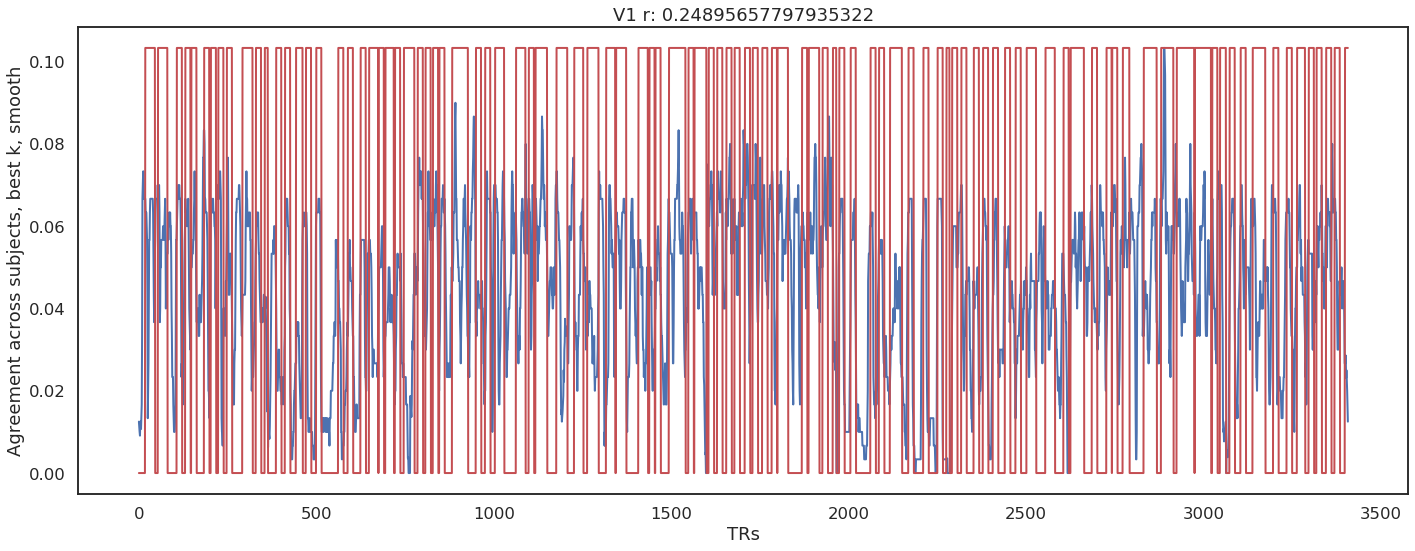

In [123]:
#perform permutation testing by (1) circularly shifting TRs within game and (2) shuffling boundaries
iters=10000 # number of iterations in permutations
smooth_agree_iter_circ_r=np.zeros((iters,nR))
smooth_agree_r=np.zeros((nR))
pp=0 #ROI column to plot
# find possession sizes for shuffling boundaries
j=0
for step in range(len(true_edges_cont_all)-1):
    if true_edges_cont_all[step+1]-true_edges_cont_all[step]==1:
        if j==0:
            posses=step+1
        else:
            posses=np.hstack([posses,step+1])
        j=j+1
posses=np.hstack([posses,len(true_edges_cont_all)])
poss_sizes=np.hstack([posses[0],np.diff(posses)])
smooth_agree_iter_r=np.zeros((iters,nR))
smooth_agree_r_diff=np.zeros((3))
smooth_agree_r_iter_diff=np.zeros((iters,3))
smooth_agree_r_iter_circ_diff=np.zeros((iters,3))
smooth_agree_r_diff_rankd=np.zeros((3))
smooth_agree_r_circ_diff_rankd=np.zeros((3))
T = true_edges_cont_smooth_all.shape
jj=0
while jj<iters+1: #loop for all permutations
    for roi in range(nR):
        roi_nameid=roi+0
        if roiparcel==2:
            roi_nameid=roi*2+1#roi+1
        a=sum_bounds_smooth_all[roi,:] #smoothed HMM transition timecourse
        if jj==0:
            b=true_edges_cont_smooth_all #smoothed possession boundary timecourse
            msk = ~np.isnan(a) & ~np.isnan(b)
            r2,p=stats.pearsonr(a[msk],b[msk]) #correlation        
            smooth_agree_r[roi]=r2 
            if roi==pp: #plot time course if desired ROI
                f, ax = plt.subplots(1,1, figsize = (20,8))
                firplot=a
                ax.plot(firplot,'b')
                ax.set_title('%s r: %s' %(ROIs[roi],smooth_agree_r[roi]))
                secplot=np.nanmax(sum_bounds_smooth_all[roi,:])*(true_edges_cont_smooth_all
                                     /np.nanmax(true_edges_cont_smooth_all[:]))
                ax.plot(secplot,'r')
                ax.set_xlabel('TRs')
                ax.set_ylabel('Agreement across subjects, best k, smooth')
                f.tight_layout()
                fign=ss_dir+'pics/HMMagreementCorrs-bestKAllGames-%s.svg' %(ROIs[roi_nameid])
                f.savefig(fign)
        else:
            true_edges_rp_circ=[]
            true_edges_rp=[]
            for game in range(tngs):
                ind=p_fl[:,0]==game+1#game_num #possessions for this particular game
                rps=np.random.permutation(sum(ind))
                rpsind=np.where(ind==1) #which poss_sizes in subset to be shuffled
                firstind=rpsind[0][0]
                firstTR=np.int(p_fl[firstind,1])
                lastind=rpsind[0][-1]
                if game+1<9:
                    lastTR=np.int(p_fl[lastind+1,1]-1)
                elif game+1==9:
                    lastTR=len(true_edges_cont_smooth_all)
                proc=0
                while proc==0: #enforce that it cannot land within 1 TR
                    proc=1
                    rps2=np.random.permutation(lastTR-firstTR) #rps2[0] is first TR in shifted data, ignore the rest
                    if rps2[0]<2:
                        proc=0
                    if rps2[0]==len(rps2):
                        proc=0
                relmat=true_edges_cont_smooth_all[firstTR:lastTR+1]
                newpossmat=np.hstack([relmat[rps2[0]:],relmat[:rps2[0]]])
                true_edges_rp_circ=np.hstack([true_edges_rp_circ,newpossmat]) #assign new edges
                #shuffle boundaries
                rpsind2=rpsind[0][rps]
                true_edges_rp=np.hstack([true_edges_rp,firstTR+np.cumsum(poss_sizes[rpsind2])]) #assign new edges
            #circ shuffle
            r2,p=stats.pearsonr(a,true_edges_rp_circ)
            smooth_agree_iter_circ_r[jj-1,roi]=r2
            #boundary shuffle
            true_edges_rp_cont=np.zeros((T))
            true_edges_rp_cont[true_edges_rp.astype(int)]=1 #put in continuous space
            true_edges_rp_cont_smooth=running_mean(true_edges_rp_cont,smoothf) #smooth
            r2,p=stats.pearsonr(sum_bounds_smooth_all[roi,:],true_edges_rp_cont_smooth)
            smooth_agree_iter_r[jj-1,roi]=r2
    if roiparcel==1:
        if jj==0: #subtract ROI differences
            smooth_agree_r_diff[0]=smooth_agree_r[0]-smooth_agree_r[1]
            smooth_agree_r_diff[1]=smooth_agree_r[0]-smooth_agree_r[2]
            smooth_agree_r_diff[2]=smooth_agree_r[1]-smooth_agree_r[2]
        else:
            smooth_agree_r_iter_diff[jj-1,0]=smooth_agree_iter_r[jj-1,0]-smooth_agree_iter_r[jj-1,1]
            smooth_agree_r_iter_diff[jj-1,1]=smooth_agree_iter_r[jj-1,0]-smooth_agree_iter_r[jj-1,2]
            smooth_agree_r_iter_diff[jj-1,2]=smooth_agree_iter_r[jj-1,1]-smooth_agree_iter_r[jj-1,2]
            smooth_agree_r_iter_circ_diff[jj-1,0]=smooth_agree_iter_circ_r[jj-1,0]-smooth_agree_iter_circ_r[jj-1,1]
            smooth_agree_r_iter_circ_diff[jj-1,1]=smooth_agree_iter_circ_r[jj-1,0]-smooth_agree_iter_circ_r[jj-1,2]
            smooth_agree_r_iter_circ_diff[jj-1,2]=smooth_agree_iter_circ_r[jj-1,1]-smooth_agree_iter_circ_r[jj-1,2]
    jj=jj+1

Correlation for each ROI in order:
[0.24895658 0.07635378 0.08774324]
Significance based on circular null distribution for each ROI in order:
[0.     0.0672 0.0286]
Significance based on scrambled boundary null distribution for each ROI in order:
[0.     0.0576 0.0028]
Correlation differences for each comparison:
[ 0.1726028   0.16121334 -0.01138947]
p value with circular distribution:
[0.0558 0.0976 0.7738]
p value with scrambled distribution:
[0.008  0.0372 0.5186]


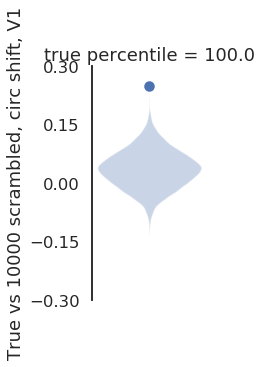

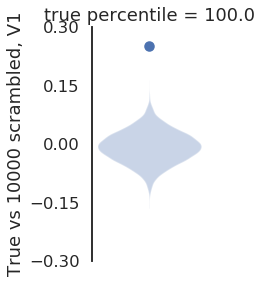

In [124]:
#create plots for Fig 3B, right side of true vs permutation
#add rankings from below!
smooth_agree_circ_r_rankd=np.zeros((nR))
smooth_agree_r_rankd=np.zeros((nR))
pp,rge=0,0.3 #roi to plot
for roi in range(nR):
    roi_nameid=roi+0
    if roiparcel==2:
        roi_nameid=roi*2+1#roi+1
    #find ranking of true among null
    smooth_agree_circ_r_rankd[roi]=stats.percentileofscore(smooth_agree_iter_circ_r[:,roi],smooth_agree_r[roi])
    if roi==pp:
        f, ax = plt.subplots(1,1, figsize = (3,4))
        yl=''
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        vplot(smooth_agree_r[roi],smooth_agree_iter_circ_r[:,roi],yl,smooth_agree_circ_r_rankd[roi],1,1,rge)
        f.tight_layout()
        fign=ss_dir+'pics/HMMBestk-AgreementVsItersCirc-bestk-%s-%s-xcond.svg' %(ROIs[roi_nameid],filtcutoff)
        f.savefig(fign)
        # add these to the plot below but not to the saved one above
        yl='''True vs %s scrambled, circ shift, %s''' %(iters,ROIs[roi_nameid])
        ax.set_ylabel(yl)
        tt='true percentile = %s' %np.round_(smooth_agree_circ_r_rankd[roi])
        ax.set_title(tt)

    #find ranking of true among null
    smooth_agree_r_rankd[roi]=stats.percentileofscore(smooth_agree_iter_r[:,roi],smooth_agree_r[roi])
    if roi==pp:
        f, ax = plt.subplots(1,1, figsize = (3,4))
        yl=''
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        vplot(smooth_agree_r[roi],smooth_agree_iter_r[:,roi],yl,smooth_agree_r_rankd[roi],1,1,rge)
        f.tight_layout()
        fign=ss_dir+'pics/HMMBestk-AgreementVsIters-bestk-%s-%s-xcond.svg' %(ROIs[roi_nameid],filtcutoff)
        f.savefig(fign)
        # add these to the plot below but not to the saved one above
        yl='''True vs %s scrambled, %s''' %(iters,ROIs[roi_nameid])
        ax.set_ylabel(yl)
        tt='true percentile = %s' %np.round_(smooth_agree_r_rankd[roi])
        ax.set_title(tt)

smooth_agree_circ_r_p=((50-np.absolute(smooth_agree_circ_r_rankd-50))*2)/100
smooth_agree_r_p=((50-np.absolute(smooth_agree_r_rankd-50))*2)/100
print('Correlation for each ROI in order:')
print(smooth_agree_r)
print('Significance based on circular null distribution for each ROI in order:')
print(smooth_agree_circ_r_p)
print('Significance based on scrambled boundary null distribution for each ROI in order:')
print(smooth_agree_r_p)

if roiparcel==1:
    smooth_agree_r_circ_diff_rankd[0]=stats.percentileofscore(smooth_agree_r_iter_circ_diff[:,0],smooth_agree_r_diff[0])
    smooth_agree_r_circ_diff_rankd[1]=stats.percentileofscore(smooth_agree_r_iter_circ_diff[:,1],smooth_agree_r_diff[1])
    smooth_agree_r_circ_diff_rankd[2]=stats.percentileofscore(smooth_agree_r_iter_circ_diff[:,2],smooth_agree_r_diff[2])
    smooth_agree_r_diff_circ_p=((50-np.absolute(smooth_agree_r_circ_diff_rankd-50))*2)/100 #smooth_agree_r_iter_circ_diff_rankd
    smooth_agree_r_diff_rankd[0]=stats.percentileofscore(smooth_agree_r_iter_diff[:,0],smooth_agree_r_diff[0])
    smooth_agree_r_diff_rankd[1]=stats.percentileofscore(smooth_agree_r_iter_diff[:,1],smooth_agree_r_diff[1])
    smooth_agree_r_diff_rankd[2]=stats.percentileofscore(smooth_agree_r_iter_diff[:,2],smooth_agree_r_diff[2])
    smooth_agree_r_diff_p=((50-np.absolute(smooth_agree_r_diff_rankd-50))*2)/100
    print('Correlation differences for each comparison:')
    print(smooth_agree_r_diff)
    print('p value with circular distribution:')
    print(smooth_agree_r_diff_circ_p)
    print('p value with scrambled distribution:')
    print(smooth_agree_r_diff_p)

In [125]:
# correlate best fitting number of states with surprise / other variables
# this involves the correlation on its own, set by 'plotmetric', as well as the combined one
plotmetric=1 #1=sur, 2=#possessions, 3=tot_mot
best_k_xsur=np.zeros((nR)) #preset variables
sur_beta=np.zeros((nR))
a=np.zeros((tngs,1))
best_k_xsur_iter_r=np.zeros((iters,nR))
best_k_xsur_iter_r_rankd=np.zeros((nR))
best_k_xsur_diff=np.zeros((3))
best_k_xsur_diff_rankd=np.zeros((3))
best_k_xsur_diff_p=np.zeros((3))
best_k_xsur_iter_diff=np.zeros((iters,3))
sur_beta_iter=np.zeros((iters,nR))
sur_beta_iter_rankd=np.zeros((nR))
b2=np.zeros((tngs,1))
blank=np.zeros((nS))
b11=gamebinsurmean.T #already converted
b22=np.divide(game_poss[:,:tngs].T,gamebindurmean[:,:tngs].T)*60 #convert to possessions / min
b33=np.divide(tot_mot[:,:tngs].T,gamebindurmean[:,:tngs].T)*60 #convert to motion / min
b44=gamebinBCsurmean.T 
b55=gamebinBICsurmean.T 
x=np.hstack([b11,b22]) #combine for regression analysis
x=np.hstack([x,b33]) #""
if plotmetric==1:
    b=b11+0
elif plotmetric==2:
    b=b22+0
elif plotmetric==3:
    b=b33+0
jj=0
while jj<iters+1:
    for r in range(nR):
        roi_nameid=r+0
        fill=best_k_xsub[:,r,:]
        a[:,0]=np.mean(fill,axis=1)
        if jj==0:
            r2,p=stats.pearsonr(a,b)
            best_k_xsur[r]=r2
            regression_model=LinearRegression()
            regression_model.fit(x,a)
            m=regression_model.coef_
            sur_beta[r]=m[0,0]          
            conc=np.hstack([a,x])
            conc=np.hstack([conc,np.ones((conc.shape[0],1))])
        else:
            fill=np.random.permutation(tngs)
            r2,p=stats.pearsonr(a[fill],b)
            best_k_xsur_iter_r[jj-1,r]=r2
            regression_model=LinearRegression()
            regression_model.fit(x,a[fill])
            m=regression_model.coef_
            sur_beta_iter[jj-1,r]=m[0,0]   
            conc=np.hstack([a[fill],x])
            conc=np.hstack([conc,np.ones((conc.shape[0],1))])
    if roiparcel==1:
        if jj==0:
            best_k_xsur_diff[0]=best_k_xsur[0]-best_k_xsur[1]
            best_k_xsur_diff[1]=best_k_xsur[0]-best_k_xsur[2]
            best_k_xsur_diff[2]=best_k_xsur[1]-best_k_xsur[2]
        else:
            best_k_xsur_iter_diff[jj-1,0]=best_k_xsur_iter_r[jj-1,0]-best_k_xsur_iter_r[jj-1,1]
            best_k_xsur_iter_diff[jj-1,1]=best_k_xsur_iter_r[jj-1,0]-best_k_xsur_iter_r[jj-1,2]
            best_k_xsur_iter_diff[jj-1,2]=best_k_xsur_iter_r[jj-1,1]-best_k_xsur_iter_r[jj-1,2]
    jj=jj+1

(9,)
(9, 1)


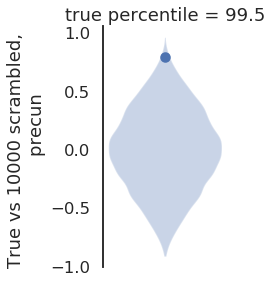

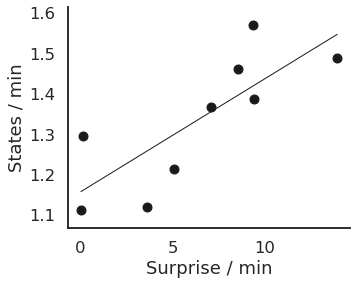

In [126]:
#find rankings + plot - becomes Fig 3C, depending on 'pp' variable and 'plotmetric' setting above
pp=2 #which ROI to plot
for r in range(nR):
    roi_nameid=r+0
    fill=best_k_xsub[:,r,:]
    a[:,0]=np.mean(fill,axis=1)
    best_k_xsur_iter_r_rankd[r]=stats.percentileofscore(best_k_xsur_iter_r[:,r],best_k_xsur[r])
    sur_beta_iter_rankd[r]=stats.percentileofscore(sur_beta_iter[:,r],sur_beta[r])
    if r==pp:
        f, ax = plt.subplots(1,1, figsize = (3,4))
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        yl=''
        vplot(best_k_xsur[r],best_k_xsur_iter_r[:,r],yl,best_k_xsur_iter_r_rankd[r],1,1,1)
        f.tight_layout()
        fign=ss_dir+'pics/BestkVSurXGame-%s-%s-xcond.svg' %(ROIs[roi_nameid],plotmetric)
        f.savefig(fign)
        yl='''True vs %s scrambled, 
        %s''' %(iters,ROIs[roi_nameid])
        ax.set_ylabel(yl)
        tt='true percentile = %s' %best_k_xsur_iter_r_rankd[r]
        ax.set_title(tt)
        f, ax = plt.subplots(1,1, figsize=(5,4))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if plotmetric==1:
            reord=[8,6,7,4,3,0,1,2,5]#mean surprise order
            xs=gamebinsurmean[0,reord] #convert to surprise / min
            xl='Surprise / min'
        elif plotmetric==2:
            reord=[5,6,0,8,4,1,2,3,7]#num poss order
            xs=np.divide(game_poss[0,reord],gamebindurmean[0,reord])*60 #convert 
            xl='# possessions / min'
        elif plotmetric==3:
            reord=[5,4,8,0,6,1,7,3,2]#vis mot order
            xs=np.divide(tot_mot[0,reord],gamebindurmean[0,reord])*60 #convert 
            xl='total visual motion / min'
        elif plotmetric==4:
            reord=[5,4,8,0,6,1,7,3,2]
            xs=gamebinBCsurmean[0,reord].T
            xl='Belief-consistent surprise / min'
        elif plotmetric==5:
            reord=[5,4,8,0,6,1,7,3,2]
            xs=gamebinBICsurmean[0,reord].T
            xl='Belief-inconsistent surprise / min'
        ys=a[reord]
        print(xs.shape)
        print(ys.shape)
        plt.scatter(xs,ys,color='k',linewidth=1)
        r2,p=stats.pearsonr(xs,ys[:,0])
        z = np.polyfit(xs, ys, 1)
        
        p = np.poly1d(z[:,0])
        plt.plot(xs,p(xs),"k",linewidth=1)
        f.tight_layout()
        fign=ss_dir+'pics/BestKVSur-%s-%s-%s.svg' %(ROIs[roi_nameid],plotmetric,filtcutoff)
        f.savefig(fign)
        ax.set_xlabel(xl)
        ax.set_ylabel('States / min')

In [ ]:
#print out some significance info, which also differs based on 'plotmetric' above
best_k_xsur_r_p=((50-np.absolute(best_k_xsur_iter_r_rankd-50))*2)/100
sur_beta_p=((50-np.absolute(sur_beta_iter_rankd-50))*2)/100
print('Correlation for each ROI in order:')
print(best_k_xsur)
print('Significance based on null distribution for each ROI in order:')
print(best_k_xsur_r_p)
print('Regression model "", significant ranked:')
print(sur_beta_p)
if roiparcel==1:
    best_k_xsur_diff_rankd[0]=stats.percentileofscore(best_k_xsur_iter_diff[:,0],best_k_xsur_diff[0])
    best_k_xsur_diff_rankd[1]=stats.percentileofscore(best_k_xsur_iter_diff[:,1],best_k_xsur_diff[1])
    best_k_xsur_diff_rankd[2]=stats.percentileofscore(best_k_xsur_iter_diff[:,2],best_k_xsur_diff[2])
    best_k_xsur_iter_diff_p=((50-np.absolute(best_k_xsur_diff_rankd-50))*2)/100
    print('ROI correlation differences for each comparison:')
    print(best_k_xsur_diff)
    print('Difference p values:')
    print(best_k_xsur_iter_diff_p)

In [ ]:
#FDR correction for parcel analysis
if roiparcel==2: 
    best_k_xsur_p=((50-np.absolute(best_k_xsur_iter_r_rankd-50))*2)/100 #p value
    best_k_xsur_q=smm.multipletests(best_k_xsur_p,alpha=0.05,method='fdr_bh') #q value
    f, ax = plt.subplots(1,1, figsize = (5,2)) 
    ax.plot(best_k_xsur,'b') 
    f, ax = plt.subplots(1,1, figsize = (5,2)) 
    ax.plot(best_k_xsur_iter_r_rankd,'b') 
    print(best_k_xsur_p) 
    print(best_k_xsur_q[1]) 

In [ ]:
#find game boundaries for graphing (as vertical dashes within a game)
a=np.mean(possHMM_xsub_all2[:,:,1],axis=0)
msk = ~np.isnan(a)
game_bounds=np.zeros((tngs+1)) #index of game boundary times
game_bounds_poss=np.zeros((tngs)) #index that will separate games from each other in matrix of all possessions
for game in range(tngs):#tngs
    fill0=p_fl[:,0]==game+1
    fill=np.where(fill0)
    fill2=fill[0][0]
    game_bounds[game]=p_fl[fill2,1]
    fill=fill0 & msk
    if game==0:
        game_bounds_poss[game]=np.sum(fill)
    else:
        game_bounds_poss[game]=np.sum(fill)+game_bounds_poss[game-1]
game_bounds[tngs]=p_fl[-1,1]
game_bounds_poss=np.hstack([0,game_bounds_poss])
game_bounds_poss=game_bounds_poss-0.5
print(game_bounds) 
print(game_bounds_poss)

In [ ]:
#quick check whether there is an overall diff b/t belief-c and belief-ic surprise
bc=np.where(p_fl[:,11]<0)
bic=np.where(p_fl[:,11]>0)
bcs=-p_fl[bc[0],11]
bics=p_fl[bic[0],11]
f, ax = plt.subplots(1,1, figsize = (20,8))
ax.hist(bcs,bins="auto")
ax.hist(bics,bins="auto")
ax.legend(['Belief-consistent surprise','Belief-inconsistent surprise'])
t,p=stats.ttest_ind(bcs,bics,nan_policy='omit')   
print('Mean & SEM for belief-consistent surprise:')
print(np.mean(bcs))
print(np.std(bcs)/bcs.shape[0])
print('Mean & SEM for belief-inconsistent surprise:')
print(np.mean(bics))
print(np.std(bics)/bics.shape[0])
print('p value of difference between conditions:')
print(p)
f, ax = plt.subplots(1,1, figsize = (20,8))
ax.hist(bcs,bins="auto")
ax.legend(['Belief-consistent surprise'])

In [ ]:
#perform cross-correlations of across-possession surprise signal and plot!
#here, we see the signal is autocorrelated, and therefore, we need to use circular 
#shifts within game
def serial_corr(wave,wave2,lag=1):
    n = len(wave)
    if lag>=0:
        y1 = wave[lag:]
        y2 = wave2[:n-lag]
    elif lag<0:
        neglag=-lag
        y1 = wave[:n-neglag]
        y2 = wave2[neglag:]
    corr = np.corrcoef(y1, y2, ddof=0)[0, 1]
    return corr
def crosscorr(wave,wave2,prange):
    lags = range(-prange,prange+1)
    corrs = [serial_corr(wave,wave2, lag) for lag in lags]
    return lags, corrs

col=6
if col==66:
    wave=(p_fl[:,6]+p_fl[:,11])/2
elif col==61:
    wave=(p_fl[:,6]-p_fl[:,11])/2
else:
    wave=p_fl[:,col] #surprise column across possessions
prange=15
p_lags=np.arange(-prange,prange+1) #+1
corrs=np.zeros((p_lags.shape[0]))
fill,fill2=crosscorr(wave,wave,prange)
corrs=fill2
f, ax = plt.subplots(1,1, figsize = (10,4))
ax.plot(p_lags,corrs,color=colpal[0]) #corrs[lb:ub]
ax.set_title('Autocorrelation of surprise across-possession signal')
ax.set_xlabel('Lag (possessions)')
ax.set_ylabel('r')
patch1 = mpatches.Patch(color=colpal[0],label='Surprise')
plt.legend(handles=[patch1])
print('r values: %s' %corrs)

In [ ]:
#create win team flip variable
#ultimately, this is underpowered (only 12 instances across all games) - not in use
wphs=np.zeros((p_fl.shape[0]))
surcol=6
for game in range(tngs):#tngs
    fill0=p_fl[:,0]==game+1
    fill=np.where(fill0)
    fill2=fill[0]
    wph=p_fl[fill2,12]
    wt=wph>50
    d=np.diff(wt)
    d2=np.where(d) 
    d2=d2[0]+1 #account for shift
    if d2.shape[0]>0:
        wphs[fill2[d2]]=p_fl[fill2[d2],surcol]
plt.plot(wphs)

In [ ]:
#HMM agreement by possession boundary for comparison to other parameters 
#which correlation to run? indicates which input to use for HMM correlation 
#6=surprise,11=belief-consistency,61=consistent,66=inconsistent,0=ev seg,1=mem,
#4=win team flip,5=inconsistent,win team no flip
col=0
pltr=20 #fig size
possHMMagree_r=np.zeros((nR))
possHMMagree_r_part=np.zeros((nR))
possHMMagree_diff_r=np.zeros((nR))
possHMMagree_diff_r2z=np.zeros((nR))
possHMMagree_pre_r=np.zeros((nR))
possHMMagree_post_r=np.zeros((nR))
if roiparcel==1:
    pp=0 #roi
elif roiparcel==2:
    pp=30 #parcel, currently precun
col2=6 #if col<2, use this as the column to correlate with event segmentation or memory
col3=1 # in case we want to look at pre versus post-possession variables, 0=pre,1=post (default)
col4=0 #if col==0, use this to partial out sur or bic 
for roi in range(nR):
    roi_nameid=roi+0
    if roiparcel==2:
        roi_nameid=roi*2+1#roi+1
    if col3==0:
        a=np.mean(pre_possHMM_xsub_all2[:,:,roi],axis=0)
    elif col3==1:
        a=np.mean(possHMM_xsub_all2[:,:,roi],axis=0)
    if col==66: #BIC sur
        b=(p_fl[:,6]+p_fl[:,11])/2
        #if BIC sur is variable of interest, also input BC sur for comparisons!
        b2=(p_fl[:,6]-p_fl[:,11])/2 
    elif col==61: #BC sur
        b=(p_fl[:,6]-p_fl[:,11])/2
    elif col==11: #negative entropy
        b=-p_fl[:,col] 
    elif col==6: #surprise
        b=p_fl[:,col] 
    elif col==4: #win team flip
        b=wphs 
    elif col==5: #BIC sur, but no flip
        b=(p_fl[:,6]+p_fl[:,11])/2-wphs #surprise column
        indd=b<0
        b[indd]=0
    elif col==0: #ev seg column
        b=evsegs[:,0] 
        if col4==0:
            d=p_fl[:,6] #for partial corr of surprise
        elif col4==1:
            d=(p_fl[:,6]-p_fl[:,11])/2 #for partial corr of bic surprise
        conc=np.vstack([a,b])
        conc=np.vstack([conc,d])
        conc=np.vstack([conc,np.ones((1,conc.shape[1]))])
        p_corr=partial_corr(conc.T)
        print('Partial Correlation=')
        print(p_corr)
        possHMMagree_r_part[roi]=p_corr[0,1]
    elif col==1:
        b=possm.T[:,0] #ev seg column
    if col<2:
        if col2==66:
            c=(p_fl[:,6]+p_fl[:,11])/2 # belief-inconsistent surprise
        elif col2==61:
            c=(p_fl[:,6]-p_fl[:,11])/2 # belief-consistent surprise
        elif col2==6:
            c=p_fl[:,col2] #surprise column
        msk = ~np.isnan(c) & ~np.isnan(b)
        r,p=stats.pearsonr(c[msk],b[msk])
        if roi==0:
            if col==0:
                print('Ev~Sur=%s' %r)
            elif col==1:
                print('Mem~Sur=%s' %r)
    
    msk = ~np.isnan(a) & ~np.isnan(b)
    r,p=stats.pearsonr(a[msk],b[msk]) # run correlation
    possHMMagree_r[roi]=r
    if col==66: #Additionally runs the difference in correlations between bc vs bic 
        msk = ~np.isnan(a) & ~np.isnan(b2)
        r2,p=stats.pearsonr(a[msk],b2[msk])
        possHMMagree_diff_r[roi]=r-r2
        r2z=np.multiply((np.log([1+r])-np.log([1-r])),0.5)
        r2_2z=np.multiply((np.log([1+r2])-np.log([1-r2])),0.5)
        possHMMagree_diff_r2z[roi]=r2z-r2_2z
    
    if roi==pp: #plot time course of ROI
        f, ax = plt.subplots(1,1, figsize = (pltr,pltr/2))
        ax.plot(a,'b')
        ax.set_title('roi: %s r: %s' %(ROIs[roi_nameid],possHMMagree_r[roi]))
        ax2=ax.twinx()
        ax2.plot(b,'r')
        ax2.vlines(game_bounds_poss,0-2,np.nanmax(b)+2,linestyles='solid')
        ax.set_xlabel('Possessions (all games)')
        fign=ss_dir+'pics/HMMagreementPossBoundVSurprise-%s-%s.svg' %(ROIs[roi_nameid],col)
        f.tight_layout()
        f.savefig(fign)
        ax.set_ylabel('''HMM state transition agreement''')
        if col==6:
            ax2.set_ylabel('Surprise at possession boundary')
        elif col==11:
            ax2.set_ylabel('Entropy change at possession boundary')  
        
print('Correlation for each ROI=')
print(possHMMagree_r)
print(np.mean(possHMMagree_r))
if col==66:
    print('Difference in correlation for each ROI=')
    print(possHMMagree_diff_r)

In [ ]:
#visualize one game - Fig 2C, though HMM state transitions for one ROI are also similarly plotted
game=4
plt.rcParams.update({'font.size':32})
xjump,yjump=5,0.2 #some plotting constants
lw3,lw4=0.5,1
ticksz=50
sursc=40 #sur scale
for roi in range(nR):
    roi_nameid=roi+0
    if roiparcel==2:
        roi_nameid=roi+1
    inddd=p_fl[:,0]==game
    a=np.mean(possHMM_xsub_all2[:,inddd,roi],axis=0) #HMM transition data
    b=p_fl[inddd,6] #surprise column
    c=p_fl[inddd,11] #entropy column
    g=p_fl[inddd,12] #win prob
    ind2=c<0
    c[ind2]=0 #bic surprise
    d=-p_fl[inddd,11] #bc surprise
    ind2=d<0
    d[ind2]=0
    if col==66:
        b=c+0#.deepcopy
    elif col==61:
        b=d+0#.deepcopy
    e=evsegs[inddd,0]
    msk = ~np.isnan(a) & ~np.isnan(b)
    a=a[msk]#toggle this on/not
    b=b[msk]#toggle
    if roi==pp: #plot all possessions for one game without axis labels (will add these in Illustrator)
        x1=np.arange(0,a.shape[0],1)
        x=np.arange(xjump,a.shape[0],xjump)
        f, ax = plt.subplots(1,1, figsize = (pltr,pltr*2/5))
        ax.plot(x1,a,'k',linewidth=lw3)
        ax.scatter(x1,a,c='k')
        ax.get_xaxis().set_visible(False)
        ax.spines['left'].set_linewidth(lw4)
        ax.tick_params(axis='both', which='major', labelsize=ticksz)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        f.tight_layout()
        plt.yticks(np.arange(0,1+yjump,0.5))
        fign=ss_dir+'pics/HMMAgreementAgreementOnly-%s-Game-%s-%s.svg' %(ROIs[roi_nameid],game,col)
        f.savefig(fign)
        f, ax = plt.subplots(1,1, figsize = (pltr,pltr*2/5))
        ax.plot(x1,g,'k',linewidth=lw3)
        ax.scatter(x1,g,c='k')
        ax.get_xaxis().set_visible(False)
        ax.spines['left'].set_linewidth(lw4)
        ax.tick_params(axis='both', which='major', labelsize=ticksz)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        f.tight_layout()
        ax.hlines(50,0,g.shape[0]-1,linestyles='dashed',linewidth=1)
        plt.yticks(np.arange(0,100+20,50))
        fign=ss_dir+'pics/HomeWinProb-%s-Game-%s-%s.svg' %(ROIs[roi_nameid],game,col)
        f.savefig(fign)
        f, ax = plt.subplots(1,1, figsize = (pltr,pltr*2/5))
        ax.plot(x1,e,'k',linewidth=lw3)
        ax.scatter(x1,e,c='k')
        ax.get_xaxis().set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_linewidth(lw4)
        ax.tick_params(axis='both', which='major', labelsize=ticksz)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        f.tight_layout()
        plt.yticks(np.arange(0,1+yjump,0.5))
        fign=ss_dir+'pics/SubjAgreementAgreementOnly-%s-Game-%s-%s.svg' %(ROIs[roi_nameid],game,col)
        f.savefig(fign)
        yjump=5
        f, ax = plt.subplots(1,1, figsize = (pltr,pltr*2/5))
        ax.plot(x1,b,'k',linewidth=lw3)
        ax.scatter(x1,b,c='k')
        ax.get_xaxis().set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_linewidth(lw4)
        ax.tick_params(axis='both', which='major', labelsize=ticksz)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        f.tight_layout()
        plt.yticks(np.arange(0,sursc+yjump,sursc/2))
        fign=ss_dir+'pics/HMMAgreementSurpriseOnly-%s-Game-%s-%s.svg' %(ROIs[roi_nameid],game,col)
        f.savefig(fign)
        f, ax = plt.subplots(1,1, figsize = (pltr,pltr*2/5))
        ax.plot(x1,d,'k',linewidth=lw3)
        ax.scatter(x1,d,c='k')
        ax.get_xaxis().set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_linewidth(lw4)
        ax.tick_params(axis='both', which='major', labelsize=ticksz)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        f.tight_layout()
        plt.yticks(np.arange(0,sursc+yjump,sursc/2))
        fign=ss_dir+'pics/HMMAgreementSurpriseConsOnly-%s-Game-%s-%s.svg' %(ROIs[roi_nameid],game,col)
        f.savefig(fign)
        f, ax = plt.subplots(1,1, figsize = (pltr,pltr*2/5))
        ax.plot(x1,c,'k',linewidth=lw3)
        ax.scatter(x1,c,c='k')
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_linewidth(lw4)
        ax.tick_params(axis='both', which='major', labelsize=ticksz)
        ax.spines['right'].set_visible(False)
        f.tight_layout()
        plt.xticks(x,np.arange(xjump,a.shape[0],xjump)) 
        plt.yticks(np.arange(0,sursc+yjump,sursc/2))
        fign=ss_dir+'pics/HMMAgreementSurpriseInconsOnly-%s-Game-%s-%s.svg' %(ROIs[roi_nameid],game,col)
        f.savefig(fign)

In [ ]:
#permutation testing for across-possession analyses
iters=10000
possHMMagree_iter_r=np.zeros((iters,nR)) # preset
possHMMagree_iter_r_part=np.zeros((iters,nR))
possHMMagree_diff_iter_r=np.zeros((iters,nR))
a0=np.mean(possHMM_xsub_all2,axis=0) #HMM state transition agreement
d=(p_fl[:,6]-p_fl[:,11])/2 #for partial corr of bic surprise
partcorr=0
possHMMagree_r_diff=np.zeros((3))
possHMMagree_iter_r_diff=np.zeros((iters,3))
possHMMagree_diff_r_diff=np.zeros((3))
possHMMagree_diff_iter_r_diff=np.zeros((iters,3))
jj=0
scram_meth=3 #1=scramble all possessions,2=scramble game order,,3=circ shift within game,4=scramble within game
while jj<iters: #
    for roi in range(nR):
        a=a0[:,roi]
        if roi==0:
            b=[]
            b2=[]
            #scramble
            if scram_meth==1: #scramble all possessions equally
                rps=np.random.permutation(p_fl.shape[0]) #create permutation matrix
                if col==66:
                    b=np.hstack([b,p_fl[rps,6]+p_fl[rps,11]])
                    b2=np.hstack([b2,p_fl[rps,6]-p_fl[rps,11]])
                elif col==61:
                    b=np.hstack([b,p_fl[rps,6]-p_fl[rps,11]])
                elif col==0:
                    b=np.hstack([b,evsegs[rps,0]]) 
                else:
                    b=np.hstack([b,p_fl[rps,col]])
            elif scram_meth==2: #scramble game order
                proc=0
                while proc==0: #proviso of not landing on same game
                    rps=np.random.permutation(tngs)
                    proc=1
                    for game in range(tngs):
                        if game==rps[game]:
                            proc=0
                #rps=np.random.permutation(tngs) #override proviso
                for game in range(tngs): #accumulate variables across games
                    game2=rps[game]
                    ind=p_fl[:,0]==game2+1 #game_num #possessions for this particular game
                    rpsind=np.where(ind==1) #which poss_sizes in subset to be shuffled
                    qq=rpsind[0]
                    if col==66:
                        relmat=p_fl[qq,6]+p_fl[qq,11]
                        relmat2=p_fl[qq,6]-p_fl[qq,11]
                    elif col==61:
                        relmat=p_fl[qq,6]-p_fl[qq,11]
                    elif col==0:
                        relmat=evsegs[qq,0]
                    else:
                        relmat=p_fl[qq,col]
                    b=np.hstack([b,relmat]) 
                    if col==66:
                        b2=np.hstack([b2,relmat2]) 
            elif scram_meth==3: #circular scramble within game
                for game in range(tngs): #accumulate variables across games
                    ind=p_fl[:,0]==game+1 #game_num #possessions for this particular game
                    rpsind=np.where(ind==1) #which poss_sizes in subset to be shuffled
                    qq=rpsind[0]
                    proc=0
                    while proc==0:
                        proc=1
                        rps=np.random.permutation(sum(ind))
                        if rps[0]<2:#2
                            proc=0
                        if rps[0]==len(rps)-1:
                            proc=0
                    if col==66:
                        relmat=p_fl[qq[0]:qq[-1]+1,6]+p_fl[qq[0]:qq[-1]+1,11]
                        relmat2=p_fl[qq[0]:qq[-1]+1,6]-p_fl[qq[0]:qq[-1]+1,11]
                    elif col==61:
                        relmat=p_fl[qq[0]:qq[-1]+1,6]-p_fl[qq[0]:qq[-1]+1,11]
                    elif col==0:
                        relmat=evsegs[qq[0]:qq[-1]+1,0]
                    else:
                        relmat=p_fl[qq[0]:qq[-1]+1,col]
                    newgamemat=np.hstack([relmat[rps[0]:],relmat[:rps[0]]])
                    b=np.hstack([b,newgamemat]) 
                    if col==66:
                        newgamemat=np.hstack([relmat2[rps[0]:],relmat2[:rps[0]]])
                        b2=np.hstack([b2,newgamemat]) 
            elif scram_meth==4: #scramble within game
                for game in range(tngs): #accumulate variables across games
                    ind=p_fl[:,0]==game+1#game_num #possessions for this particular game
                    rps=np.random.permutation(sum(ind)) #shuffle games
                    rpsind=np.where(ind==1) #which poss_sizes in subset to be shuffled
                    qq=rpsind[0]
                    #print(qq[rps])  
                    if col==66:
                        b=np.hstack([b,p_fl[qq[rps],6]+p_fl[qq[rps],11]])
                        b2=np.hstack([b2,p_fl[qq[rps],6]-p_fl[qq[rps],11]])
                    elif col==61:
                        b=np.hstack([b,p_fl[qq[rps],6]-p_fl[qq[rps],11]])
                    elif col==0:
                        b=np.hstack([b,evsegs[qq[rps],0]]) 
                    else:
                        b=np.hstack([b,p_fl[qq[rps],col]])
            elif scram_meth==5: #circular scramble across all games
                ind=p_fl[:,0]<tngs+1 #all games
                rpsind=np.where(ind==1) #all games
                qq=rpsind[0] #index of all games
                
                proc=0
                while proc==0:
                    proc=1
                    rps=np.random.permutation(p_fl.shape[0])
                    #print(rps[0])
                    if rps[0]<2:
                        proc=0
                        print('iter=%s' %jj)
                    if rps[0]==len(rps)-1:
                        proc=0
                        print('iter2=%s' %jj)
                if col==66:
                    relmat=p_fl[qq[0]:qq[-1]+1,6]+p_fl[qq[0]:qq[-1]+1,11]
                    relmat2=p_fl[qq[0]:qq[-1]+1,6]-p_fl[qq[0]:qq[-1]+1,11]
                elif col==61:
                    relmat=p_fl[qq[0]:qq[-1]+1,6]-p_fl[qq[0]:qq[-1]+1,11]
                elif col==0:
                    relmat=evsegs[qq[0]:qq[-1]+1,0]
                else:
                    relmat=p_fl[qq[0]:qq[-1]+1,col]
                newgamemat=np.hstack([relmat[rps[0]:],relmat[:rps[0]]])
                b=np.hstack([b,newgamemat]) 
                if col==66:
                    newgamemat=np.hstack([relmat2[rps[0]:],relmat2[:rps[0]]])
                    b2=np.hstack([b2,newgamemat]) 
        msk = ~np.isnan(a) & ~np.isnan(b)
        r,p=stats.pearsonr(a[msk],b[msk]) #run correlation
        possHMMagree_iter_r[jj,roi]=r
        if partcorr==1: #for partial correlations, rebuild on each iteration
            if col==0:
                conc=np.vstack([a,b])
                conc=np.vstack([conc,d])
                conc=np.vstack([conc,np.ones((1,conc.shape[1]))])
                p_corr=partial_corr(conc.T)
                possHMMagree_iter_r_part[jj,roi]=p_corr[0,1]
        if col==66: #find null distribution of difference between bc vs bic
            msk = ~np.isnan(a) & ~np.isnan(b2)
            r2,p=stats.pearsonr(a[msk],b2[msk])
            possHMMagree_diff_iter_r[jj,roi]=r-r2
    possHMMagree_r_diff[0]=possHMMagree_r[0]-possHMMagree_r[1]
    possHMMagree_r_diff[1]=possHMMagree_r[0]-possHMMagree_r[2]
    possHMMagree_r_diff[2]=possHMMagree_r[1]-possHMMagree_r[2]
    possHMMagree_iter_r_diff[jj,0]=possHMMagree_iter_r[jj,0]-possHMMagree_iter_r[jj,1]
    possHMMagree_iter_r_diff[jj,1]=possHMMagree_iter_r[jj,0]-possHMMagree_iter_r[jj,2]
    possHMMagree_iter_r_diff[jj,2]=possHMMagree_iter_r[jj,1]-possHMMagree_iter_r[jj,2]
    if col==66:
        possHMMagree_diff_r_diff[0]=possHMMagree_diff_r[0]-possHMMagree_diff_r[1]
        possHMMagree_diff_r_diff[1]=possHMMagree_diff_r[0]-possHMMagree_diff_r[2]
        possHMMagree_diff_r_diff[2]=possHMMagree_diff_r[1]-possHMMagree_diff_r[2]
        possHMMagree_diff_iter_r_diff[jj,0]=possHMMagree_diff_iter_r[jj,0]-possHMMagree_diff_iter_r[jj,1]
        possHMMagree_diff_iter_r_diff[jj,1]=possHMMagree_diff_iter_r[jj,0]-possHMMagree_diff_iter_r[jj,2]
        possHMMagree_diff_iter_r_diff[jj,2]=possHMMagree_diff_iter_r[jj,1]-possHMMagree_diff_iter_r[jj,2]
    
    jj=jj+1

In [ ]:
#plot true vs null distributions for correlations run above
a0_r=possHMMagree_r #true correlation coefficient
a0_diff_r=possHMMagree_diff_r #correlation coefficient difference between bc vs bic
a0_diff_r_diff=possHMMagree_diff_r_diff #correlation coefficient ROI difference between bc vs bic
possHMMagree_r_rankd=np.zeros((nR)) #presets
possHMMagree_r_p=np.zeros((nR))
possHMMagree_r_rankd_part=np.zeros((nR))
possHMMagree_r_p_part=np.zeros((nR))
possHMMagree_diff_r_rankd=np.zeros((nR))
possHMMagree_diff_r_p=np.zeros((nR))
possHMMagree_diff_r_diff_rankd=np.zeros((nR))
possHMMagree_diff_r_diff_p=np.zeros((nR))
possHMMagree_iter_r_diff_rankd=np.zeros((nR))
pp=1
for roi in range(nR):
    roi_nameid=roi+0
    if roiparcel==2:
        roi_nameid=roi*2+1 #roi+1 #method to assign correct parcel ID
    #find rankings of true vs null
    possHMMagree_r_rankd[roi]=stats.percentileofscore(possHMMagree_iter_r[:,roi],a0_r[roi])
    possHMMagree_r_rankd_part[roi]=stats.percentileofscore(possHMMagree_iter_r_part[:,roi],possHMMagree_r_part[roi])
    #calculate p value (two-tailed, so need to halve the ranking)
    if possHMMagree_r_rankd[roi]<50:
        possHMMagree_r_p[roi]=possHMMagree_r_rankd[roi]*2
    else:
        possHMMagree_r_p[roi]=(100-possHMMagree_r_rankd[roi])*2
    if partcorr==1:
        if col==0:
                if possHMMagree_r_rankd_part[roi]<50:
                    possHMMagree_r_p_part[roi]=possHMMagree_r_rankd_part[roi]*2
                else:
                    possHMMagree_r_p_part[roi]=(100-possHMMagree_r_rankd_part[roi])*2
    if col==66:
        possHMMagree_diff_r_rankd[roi]=stats.percentileofscore(possHMMagree_diff_iter_r[:,roi],a0_diff_r[roi])
        if possHMMagree_diff_r_rankd[roi]<50:
            possHMMagree_diff_r_p[roi]=possHMMagree_diff_r_rankd[roi]*2
        else:
            possHMMagree_diff_r_p[roi]=(100-possHMMagree_diff_r_rankd[roi])*2
        if roiparcel==1:
            possHMMagree_diff_r_diff_rankd[roi]=stats.percentileofscore(possHMMagree_diff_iter_r_diff[:,roi],a0_diff_r_diff[roi])
            if possHMMagree_diff_r_diff_rankd[roi]<50:
                possHMMagree_diff_r_diff_p[roi]=possHMMagree_diff_r_diff_rankd[roi]*2
            else:
                possHMMagree_diff_r_diff_p[roi]=(100-possHMMagree_diff_r_diff_rankd[roi])*2
    if roi==pp: #plot true vs null
        f, ax = plt.subplots(1,1, figsize = (3,4))
        yl=''
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        vplot(possHMMagree_r[roi],possHMMagree_iter_r[:,roi],yl,possHMMagree_r_rankd[roi],1,1,0.4)
        f.tight_layout()
        fign=ss_dir+'pics/HMMPossAgreementVsIters-bestk-%s-%s-%s-%s-xcond.svg' %(ROIs[roi_nameid],col,pp,nanend)
        f.savefig(fign)
        yl='''True vs scrambled, %s''' %(ROIs[roi_nameid])
        ax.set_ylabel(yl)
        tt='true percentile = %s' %np.round_(possHMMagree_r_rankd[roi])
        ax.set_title(tt)

possHMMagree_iter_r_diff_rankd[0]=stats.percentileofscore(possHMMagree_iter_r_diff[:,0],possHMMagree_r_diff[0])
possHMMagree_iter_r_diff_rankd[1]=stats.percentileofscore(possHMMagree_iter_r_diff[:,1],possHMMagree_r_diff[1])
possHMMagree_iter_r_diff_rankd[2]=stats.percentileofscore(possHMMagree_iter_r_diff[:,2],possHMMagree_r_diff[2])
    
#calculate p values (and q values for parcels) and print
possHMMagree_r_p=((50-np.absolute(possHMMagree_r_rankd-50))*2)/100
possHMMagree_r_diff_p=((50-np.absolute(possHMMagree_iter_r_diff_rankd-50))*2)/100
print('Correlation coefficient and p value:')
print(possHMMagree_r)
print(possHMMagree_r_p)
print('Correlation differences among ROIs for each comparison:')
print(possHMMagree_r_diff)
print('ROI difference p value:')
print(possHMMagree_r_diff_p)
#if roiparcel==2:
msk=~np.isnan(possHMMagree_r_p)
possHMMagree_r_q=smm.multipletests(possHMMagree_r_p[msk],alpha=0.05,method='fdr_bh')
if partcorr==1:
    if col==0:
        possHMMagree_r_p_part=((50-np.absolute(possHMMagree_r_rankd_part-50))*2)/100
        print('(Partial) correlation coefficient and p value:')
        print(possHMMagree_r_part)
        print(possHMMagree_r_p_part)
if col==66:
    possHMMagree_diff_r_p=((50-np.absolute(possHMMagree_diff_r_rankd-50))*2)/100
    print('BC-BIC Correlation coefficient difference and p value:')
    print(possHMMagree_diff_r)
    print(possHMMagree_diff_r_p)
    print('Correlation differences among ROIs for each comparison and p value:')
    if roiparcel==1:
        print(possHMMagree_diff_r_diff)
        print(possHMMagree_diff_r_diff_p)
    if roiparcel==2:
        msk=~np.isnan(possHMMagree_diff_r_p)
        possHMMagree_diff_r_q=smm.multipletests(possHMMagree_diff_r_p[msk],alpha=0.05,method='fdr_bh')
        

In [ ]:
#across-parcel analysis
if roiparcel==2:
    if col==66:
        a0=np.mean(possHMM_xsub_all2,axis=0) #HMM state transition agreement
        xparcdiff_r_diffnoz=np.median(possHMMagree_diff_r)
        print(xparcdiff_r_diffnoz)
        xparcdiff_r_diff=np.median(possHMMagree_diff_r2z)
        print(xparcdiff_r_diff)
        xparcdiff_iter_r_diff=np.zeros((iters,1))
        jj=0
        while jj<iters:
            b=[]
            b2=[]
            #scramble first
            for game in range(tngs): #accumulate variables across games
                ind=p_fl[:,0]==game+1#game_num #possessions for this particular game
                rps=np.random.permutation(sum(ind))
                rpsind=np.where(ind==1) #which poss_sizes in subset to be shuffled
                qq=rpsind[0]
                #print(qq[rps])   
                b=np.hstack([b,p_fl[qq[rps],6]+p_fl[qq[rps],11]])
                b2=np.hstack([b2,p_fl[qq[rps],6]-p_fl[qq[rps],11]])
            if scramall==1: #not within-game
                b=[]
                b2=[]
                rps=np.random.permutation(p_fl.shape[0])
                b=np.hstack([b,p_fl[rps,6]+p_fl[rps,11]])
                b2=np.hstack([b2,p_fl[rps,6]-p_fl[rps,11]])
            if jj<1:
                print(b)
            bicbcsurtemp=np.zeros((nR,1))
            for roi in range(nR):
                a=a0[:,roi]
                msk = ~np.isnan(a) & ~np.isnan(b)
                r,p=stats.pearsonr(a[msk],b[msk]) #run correlation
                msk = ~np.isnan(a) & ~np.isnan(b2)
                r2,p=stats.pearsonr(a[msk],b2[msk])
                r2z=np.multiply((np.log([1+r])-np.log([1-r])),0.5)
                r2_2z=np.multiply((np.log([1+r2])-np.log([1-r2])),0.5)
                bicbcsurtemp[roi]=r2z-r2_2z
            xparcdiff_iter_r_diff[jj,0]=np.median(bicbcsurtemp)
            jj=jj+1
        xparcdiff_rankd=stats.percentileofscore(xparcdiff_iter_r_diff,xparcdiff_r_diff)
        print(xparcdiff_rankd)
        f, ax = plt.subplots(1,1, figsize = (3,4))
        yl=''
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        vplot(xparcdiff_r_diff,xparcdiff_iter_r_diff,yl,xparcdiff_rankd,1,1,0.2)
        f.tight_layout()
        fign=ss_dir+'pics/HMMXParcelsBCBIC-%s-xcond.svg' %(nanend)
        #f.savefig(fign)
        yl='''True vs scrambled'''
        ax.set_ylabel(yl)
        tt='true percentile = %s' %np.round_(xparcdiff_rankd)
        ax.set_title(tt)

In [ ]:
# print for output to Supplementary Table 1 (if running parcel analyses)
# note: need to change 'col' up above a few times to get each of the relevant values
if roiparcel==2:
    for r in range(1,nR+1):
        print('%s' %(ROIs[(r-1)*2+1]))
    print('')
    for r in range(nR):
        print(np.mean(np.mean(best_k_xsub[:,r,:],axis=0).T,axis=0))
    print('')
    for r in range(nR):
        print(possHMMagree_r[r].T)
    print('')
    for r in range(nR):
        print(possHMMagree_r_p[r])
    msk=~np.isnan(possHMMagree_r_p)
    print('msk shape=%s' %np.sum(msk))
    print('')
    for r in range(np.sum(msk)):
        print(possHMMagree_r_q[1][r])
    if col==66:
        print('diff')
        for r in range(nR):
            print(possHMMagree_diff_r[r].T)
        print('diffp')
        for r in range(nR):
            print(possHMMagree_diff_r_p[r].T)
        print('diffq')
        msk=~np.isnan(possHMMagree_diff_r_p)
        for r in range(np.sum(msk)):
            print(possHMMagree_diff_r_q[1][r])

In [ ]:
#across-parcel analysis, KN suggestion - not in use
scramall=1
if roiparcel==2:
    if col==66:
        a0=np.mean(possHMM_xsub_all2,axis=0) #HMM state transition agreement
        xparcdiff_r_diffnoz=np.mean(possHMMagree_diff_r)
        print(xparcdiff_r_diffnoz)
        aa=np.where(possHMMagree_diff_r2z>0)
        xparcdiff_r_diff=aa[0].shape[0]
        print(xparcdiff_r_diff)
        xparcdiff_iter_r_diff=np.zeros((iters,1))
        jj=0
        b=p_fl[:,6]+p_fl[:,11]
        b2=p_fl[:,6]-p_fl[:,11]
        while jj<iters:
            #scramble first
            qqs=[]
            for game in range(tngs): #accumulate variables across games
                ind=p_fl[:,0]==game+1#game_num #possessions for this particular game
                rps=np.random.permutation(sum(ind))
                rpsind=np.where(ind==1) #which poss_sizes in subset to be shuffled
                qq=rpsind[0]
                qqs=np.hstack([qqs,qq[rps]])
            qqs=qqs.astype(int)
            if scramall==1: #not within-game
                qqs=[]
                rps=np.random.permutation(p_fl.shape[0])
                qqs=rps#np.hstack([qqs,rps])
            if jj<1:
                print(qqs)
            bicbcsurtemp=np.zeros((nR,1))
            for roi in range(nR):
                a=a0[qqs,roi]
                msk = ~np.isnan(a) & ~np.isnan(b)
                r,p=stats.pearsonr(a[msk],b[msk]) #run correlation
                msk = ~np.isnan(a) & ~np.isnan(b2)
                r2,p=stats.pearsonr(a[msk],b2[msk])
                r2z=np.multiply((np.log([1+r])-np.log([1-r])),0.5)
                r2_2z=np.multiply((np.log([1+r2])-np.log([1-r2])),0.5)
                bicbcsurtemp[roi]=r2z-r2_2z
            aa=np.where(bicbcsurtemp>0)
            #xparcdiff_iter_r_diff[jj,0]=np.mean(bicbcsurtemp)#median
            xparcdiff_iter_r_diff[jj,0]=aa[0].shape[0]
            jj=jj+1
        xparcdiff_rankd=stats.percentileofscore(xparcdiff_iter_r_diff,xparcdiff_r_diff)
        print(xparcdiff_rankd)
        f, ax = plt.subplots(1,1, figsize = (3,4))
        yl=''
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        vplot(xparcdiff_r_diff,xparcdiff_iter_r_diff,yl,xparcdiff_rankd,1,1,48)#0.2
        f.tight_layout()
        fign=ss_dir+'pics/HMMXParcelsBCBICScramHMM-%s-xcond.svg' %(nanend)
        #f.savefig(fign)
        yl='''# parcels BIC r - BC r > 0'''
        #yl='''True vs scrambled'''
        ax.set_ylabel(yl)
        tt='true percentile = %s' %np.round_(xparcdiff_rankd)
        ax.set_title(tt)

In [ ]:
#plot game-level correlations of enjoyment w/ various other variables - Fig S4A 
#(the top plot below). here we will plot these across-game correlations by 
#"reordering" the relevant variables for  presentation purposes, based on their 
#idiosyncratic orders
if roiparcel==1:
    if exportR: #export best K at game level!!
        sz=6
        fn=rdir+'Event_HMM_XCond-ROI-R.csv'
        pp1=0
        pp2=1
        with open(fn, mode='w') as rfile:
            employee_writer = csv.writer(rfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            employee_writer.writerow(['Sub_num', 'Game_num', 'Sur','BestKV1','BestKvmPFC','Enjoy'])
            for sub in range(nS):
                for game in range(tngs):
                    c=gamebinsurmean[0,game]
                    d=np.mean(best_k_xsub[game,pp1,:],axis=0)
                    e=np.mean(best_k_xsub[game,pp2,:],axis=0)
                    f=enjoy_all[sub,game]
                    employee_writer.writerow([sub+1,game+1,c,d,e,f])
                    
    ticksz=20
    reord=[5,2,1,0,3,4,7,6,8]#mean surprise order reord=[5,1,2,0,3,4,7,6,8]
    xs=gamebinsurmean[0,reord]
    enjs=np.mean(enjoy_all,axis=0)
    ys=enjs[reord]
    enjs_s=np.std(enjoy_all,axis=0)/np.sqrt(nS)
    errs=enjs_s[reord]
    r,p=stats.pearsonr(xs,ys)
    print('Enj~Sur mean, r=%s,p=%s' %(r,p))
    f, ax = plt.subplots(1,1, figsize=(sz,sz))#/2
    plt.errorbar(xs,ys,yerr=errs,color='k',ecolor='k',linewidth=lw4)
    #ax.get_xaxis().set_visible(False)
    ax.spines['left'].set_linewidth(lw4)
    ax.tick_params(axis='both',which='major',labelsize=ticksz,direction='out')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(lw4)
    ax.spines['right'].set_visible(False)
    f.tight_layout()
    plt.yticks(np.arange(1,8,3))
    #plt.xticks(np.arange(0,5,10))
    f.tight_layout()
    fign=ss_dir+'pics/EnjVSurErrBar.svg'
    f.savefig(fign)
    ax.set_xlabel('Surprise',fontsize=ticksz)
    ax.set_ylabel('Enjoyment (/7)',fontsize=ticksz)
    
    reord=[1,3,0,5,2,4,7,6,8]#mean surprise order
    xs=gamebinsurstdev[0,reord] #any order is fine
    r,p=stats.pearsonr(xs,ys)
    print('Enj~Sur st dev, r=%s,p=%s' %(r,p))
    f, ax = plt.subplots(1,1, figsize=(sz,sz))#/2
    plt.errorbar(xs,ys,yerr=errs,color='k',ecolor='k',linewidth=lw4)
    #ax.get_xaxis().set_visible(False)
    ax.spines['left'].set_linewidth(lw4)
    ax.tick_params(axis='both',which='major',labelsize=ticksz,direction='out')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(lw4)
    ax.spines['right'].set_visible(False)
    f.tight_layout()
    plt.yticks(np.arange(1,8,3))
    fign=ss_dir+'pics/EnjVSurStDevErrBar.svg'
    f.savefig(fign)

In [ ]:
#plot best K / minute for each parcel (i.e., cortical hierarchy of timescales) - Fig S3A
if roiparcel==2:
    psz=10
    threshold= 0.01
    parcel_graph=np.zeros(brain_nii.shape) #preset
    #grab mean best K across subjects and games
    y=np.mean(best_k_xsub,axis=0).T 
    y=np.mean(y,axis=0)
    print(y.shape)
    for parcel in range(nR):
        fill2 = np.logical_and(index>parcel*2,index<parcel*2+3)# rm background region & bilateralize
        parcel_coords=np.logical_and(brain_mask>0,fill2>0)
        parcel_graph[parcel_coords]=y[parcel] #assign all voxels of that parcel to best K for the region
    parcel_graph_nifti = nib.Nifti1Image(parcel_graph, brain_nii.affine, brain_nii.header)
    if ipynby==1:
        f, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': '3d'})
        plot_roi(parcel_graph_nifti, bg_img=template0, title='best k / minute',
                 threshold=threshold, colorbar=True,cmap='jet',axes=ax)
        f.tight_layout()
        fign=ss_dir+'pics/ParcelCombineLRBestKBrain.svg' #plots ROI in volume space
        f.savefig(fign)
        # convert from volume to surface space
        fsaverage=datasets.fetch_surf_fsaverage5() # get a surface
        fign=ss_dir+'pics/ParcelCombineLRBestK-Surface-'
        plotsurface(parcel_graph_nifti,threshold,psz,fign)

In [ ]:
#plot correlation of HMM transitions vs surprise measure for each parcel
# when col=6, this produces Fig S3B; when col=66, Fig S3C; when col=0, Fig S3E
if roiparcel==2:
    parcel_graph=np.zeros(brain_nii.shape)
    y=possHMMagree_r
    for parcel in range(nR):
        fill2 = np.logical_and(index>parcel*2,index<parcel*2+3)# rm background region 
        parcel_coords=np.logical_and(brain_mask>0,fill2>0)
        parcel_graph[parcel_coords]=y[parcel]
    parcel_graph_nifti = nib.Nifti1Image(parcel_graph, brain_nii.affine, brain_nii.header)
    if ipynby==1:
        f, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': '3d'})
        plot_roi(parcel_graph_nifti, bg_img=template0, title='HMM transition vs surprise',
                 threshold=threshold, colorbar=True,cmap='jet',axes=ax)
        f.tight_layout()
        fign=ss_dir+'pics/ParcelCombineLRHMMvSurBrain-%s.svg' %col
        f.savefig(fign)
        # convert from volume to surface space
        fsaverage=datasets.fetch_surf_fsaverage5() # get a surface
        fign=ss_dir+'pics/ParcelCombineLRHMMvSur-Surface-Spesh-%s-' %col
        plotsurface(parcel_graph_nifti,threshold,psz,fign)

In [ ]:
#plot correlation of HMM transitions vs difference between bc and bic surprise for each parcel
# when col=66, this produces Fig S3D
if roiparcel==2:
    if col==66:
        parcel_graph=np.zeros(brain_nii.shape)
        y=possHMMagree_diff_r
        for parcel in range(nR):
            fill2 = np.logical_and(index>parcel*2,index<parcel*2+3)# rm background region 
            parcel_coords=np.logical_and(brain_mask>0,fill2>0)
            parcel_graph[parcel_coords]=y[parcel]
        parcel_graph_nifti = nib.Nifti1Image(parcel_graph, brain_nii.affine, brain_nii.header)
        if ipynby==1:
            f, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': '3d'})
            plot_roi(parcel_graph_nifti, bg_img=template0, title='HMM transition vs surprise',
                     threshold=threshold, colorbar=True,cmap='jet',axes=ax)
            f.tight_layout()
            fign=ss_dir+'pics/ParcelCombineLRHMMvBCvHMMvBICBrain-%s.svg' %col
            f.savefig(fign)
            # convert from volume to surface space
            fsaverage=datasets.fetch_surf_fsaverage5() # get a surface
            fign=ss_dir+'pics/ParcelCombineLRHMMvBCvHMMvBIC-Surface-%s-' %col
            plotsurface(parcel_graph_nifti,threshold,psz,fign)

In [ ]:
#best k / minute vs across-game surprise
if roiparcel==2:
    parcel_graph=np.zeros(brain_nii.shape)
    y=best_k_xsur
    for parcel in range(nR):
        fill2 = np.logical_and(index>parcel*2,index<parcel*2+3)# rm background region 
        parcel_coords=np.logical_and(brain_mask>0,fill2>0)
        parcel_graph[parcel_coords]=y[parcel]
    parcel_graph_nifti = nib.Nifti1Image(parcel_graph, brain_nii.affine, brain_nii.header)
    if ipynby==1:
        f, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': '3d'})
        plot_roi(parcel_graph_nifti, bg_img=template0, title='best k / minute vs across-game surprise',
                 threshold=threshold, colorbar=True,cmap='jet',axes=ax)
        f.tight_layout()
        fign=ss_dir+'pics/ParcelCombineLRBestKSurpBrain-%s.svg' %col
        f.savefig(fign)
        # convert from volume to surface space
        fsaverage=datasets.fetch_surf_fsaverage5() # get a surface
        fign=ss_dir+'pics/ParcelCombineLRBestKSurp-Surface-%s-' %col
        plotsurface(parcel_graph_nifti,threshold,psz,fign)

In [ ]:
#univariate analyses time-locked to event boundaries, HMM transitions, etc.
# note: only VTA result is in the paper in Fig S6
rg=15
bl1=-12#-12
bl2=-8#-8
preclust1=-3
preclust2=0
postclust1=-2#1
postclust2=10#14
vtaclust1=-2
vtaclust2=-2
axx=np.arange(-rg,rg+1)
HC_tc_a=np.zeros((nS,rg*2+1))
VTA_tc_a=np.zeros((nS,rg*2+1))
NAcc_tc_a=np.zeros((nS,rg*2+1))
HC_tc_l_a=np.zeros((nS,rg*2+1))
VTA_tc_l_a=np.zeros((nS,rg*2+1))
HC_early_post=np.zeros((nS,nPoss))
HC_late_post=np.zeros((nS,nPoss))
VTA_early_post=np.zeros((nS,nPoss))
boundtype=0
splitbypp=0#1=split by whether a HMM boundary or not (only if boundtype=0),2=split by belief-c or bic
pp=2 #only if splitbypp=1
HC_VTA_corr=np.zeros((nS))
HCpre_VTA_corr=np.zeros((nS))
for s in range(nS):
    if boundtype==0:
        bmat=true_edges_cont_all
        bmat2=bounds_subj_all[pp,:,s]
    else:
        bmat=bounds_subj_all[pp,:,s]
    n_ev=int(np.sum(bmat))
    proc_ev=np.zeros((n_ev))
    ev_w=np.where(bmat==1)
    evs=np.zeros((nPoss))
    j=0
    jj=0
    jp=0
    jn=0
    for ev in range(n_ev):
        proceed=0
        proceed_l=0
        rg_act=int(ev_w[0][ev])
        rg_f=int(ev_w[0][ev]-rg)
        rg_e=int(ev_w[0][ev]+rg)
        if splitbypp==0: #don't split up
            proceed=1
        else:
            rg2_f=int(ev_w[0][ev])
            rg2_e=int(ev_w[0][ev]+rg*2)
        if splitbypp==1: #split by only if there's a HMM boundary
            if np.sum(bmat2[rg2_f:rg2_e+1])>0:
                proceed=1
            elif np.sum(bmat2[rg2_f:rg2_e+1])==0:
                proceed_l=1
        elif splitbypp==2: #split by belief-cons or incons
            if np.sum(surprise_unsigned_bc[rg2_f:rg2_e+1])>np.sum(surprise_unsigned_bic[rg2_f:rg2_e+1]):
                proceed=1
            else:
                proceed_l=1
        if proceed==1:
            proc_ev[ev]=1
            if rg_f>0:
                if rg_e+1<nTR:
                    j=j+1
                    if j==1:
                        stash=HC_m_all[s,rg_f:rg_e+1]
                        stash_vta=VTA2_m_all[s,rg_f:rg_e+1]#NAcc
                        stash_nacc=NAcc_m_all[s,rg_f:rg_e+1]
                    else:
                        stash=np.vstack([stash,HC_m_all[s,rg_f:rg_e+1]])
                        stash_vta=np.vstack([stash_vta,VTA2_m_all[s,rg_f:rg_e+1]])
                        stash_nacc=np.vstack([stash_nacc,NAcc_m_all[s,rg_f:rg_e+1]])
        elif proceed_l==1:
            proc_ev[ev]=1
            if rg_f>0:
                if rg_e+1<nTR:
                    jj=jj+1
                    if jj==1:
                        stash_l=HC_m_all[s,rg_f:rg_e+1]
                        stash_vta_l=VTA2_m_all[s,rg_f:rg_e+1]
                    else:
                        stash_l=np.vstack([stash_l,HC_m_all[s,rg_f:rg_e+1]])
                        stash_vta_l=np.vstack([stash_vta_l,VTA2_m_all[s,rg_f:rg_e+1]])
                        
    HC_tc_a[s,:]=np.nanmean(stash,axis=0)
    VTA_tc_a[s,:]=np.nanmean(stash_vta,axis=0)
    NAcc_tc_a[s,:]=np.nanmean(stash_nacc,axis=0)
    if splitbypp>0:
        HC_tc_l_a[s,:]=np.nanmean(stash_l,axis=0)
        VTA_tc_l_a[s,:]=np.nanmean(stash_vta_l,axis=0)
    a=np.nanmean(stash[:,rg+postclust1:rg+1+postclust2],axis=1)#-np.mean(stash[:,rg+bl1:rg+1+bl2],axis=1)#baseline
    b=np.nanmean(stash_vta[:,rg+vtaclust1:rg+1+vtaclust2],axis=1)-np.nanmean(stash_vta[:,rg+bl1:rg+1+bl2],axis=1)#baseline
    c=np.nanmean(stash[:,rg+preclust1:rg+1+preclust2],axis=1)-np.nanmean(stash[:,rg+bl1:rg+1+bl2],axis=1)#baseline
    r,p=stats.pearsonr(a,b)
    r=np.multiply((np.log([1+r])-np.log([1-r])),0.5)
    HC_VTA_corr[s]=r
    r,p=stats.pearsonr(c,b)
    r=np.multiply((np.log([1+r])-np.log([1-r])),0.5)
    HCpre_VTA_corr[s]=r
    erows=evs==0
    if boundtype==0:
        if splitbypp==0:
            fill=np.where(proc_ev==1)
            HC_late_post[s,:nPoss-1]=a
            VTA_early_post[s,:nPoss-1]=b
            HC_early_post[s,:nPoss-1]=c
            if nanend:
                HC_late_post[s,evwherenot]=float('nan')
                VTA_early_post[s,evwherenot]=float('nan')
                HC_early_post[s,evwherenot]=float('nan')

In [ ]:
if ipynby==1:
    sz=4
    f, ax = plt.subplots(1,1, figsize=(sz,sz))
    ax.errorbar(axx,np.mean(HC_tc_a,axis=0),yerr=np.divide(np.std(HC_tc_a,axis=0),
                np.sqrt(HC_tc_a.shape[0])),color='#1f77b4')
    if boundtype==0:
        ax.set_xlabel('Time (relative to possession boundary)')
    else:
        ax.set_xlabel('Time (relative to HMM boundary in %s)' %ROIs[pp])
    ax.set_ylabel('BOLD activation (AU)')
    hc_patch = mpatches.Patch(color='#1f77b4', label='HC')
    if splitbypp==0:
        plt.legend(handles=[hc_patch])
    elif splitbypp==1:
        ax.errorbar(axx,np.mean(HC_tc_l_a,axis=0),yerr=np.divide(np.std(HC_tc_l_a,axis=0),
                np.sqrt(HC_tc_l_a.shape[0])),color='#ff7f0e')
        hc_patch = mpatches.Patch(color='#1f77b4', label='HC_Bound')
        hc_l_patch = mpatches.Patch(color='#ff7f0e', label='HC_NoBound')
        plt.legend(handles=[hc_patch,hc_l_patch])
    elif splitbypp==2:
        ax.errorbar(axx,np.mean(HC_tc_l_a,axis=0),yerr=np.divide(np.std(HC_tc_l_a,axis=0),
                np.sqrt(HC_tc_l_a.shape[0])),color='#ff7f0e')
        hc_patch = mpatches.Patch(color='#1f77b4', label='HC_BC')
        hc_l_patch = mpatches.Patch(color='#ff7f0e', label='HC_BIC')
        plt.legend(handles=[hc_patch,hc_l_patch])
        
    f, ax = plt.subplots(1,1, figsize=(sz,sz*3/4))
    ax.errorbar(axx,np.mean(VTA_tc_a,axis=0),yerr=np.divide(np.std(VTA_tc_a,axis=0),
                np.sqrt(VTA_tc_a.shape[0])),color='#1f77b4')
    f.tight_layout()
    fign=ss_dir+'pics/VTAact.svg'
    f.savefig(fign)
    vta_patch = mpatches.Patch(color='#1f77b4', label='VTA')
    if splitbypp==0:
        plt.legend(handles=[vta_patch])
    elif splitbypp==1:
        ax.errorbar(axx,np.mean(VTA_tc_l_a,axis=0),yerr=np.divide(np.std(VTA_tc_l_a,axis=0),
                np.sqrt(VTA_tc_l_a.shape[0])),color='#1f77b4')
        vta_patch = mpatches.Patch(color='#1f77b4', label='VTA_Bound')
        vta_l_patch = mpatches.Patch(color='#ff7f0e', label='VTA_NoBound')
        plt.legend(handles=[vta_patch,vta_l_patch])
    elif splitbypp==2:
        ax.errorbar(axx,np.mean(VTA_tc_l_a,axis=0),yerr=np.divide(np.std(VTA_tc_l_a,axis=0),
                np.sqrt(VTA_tc_l_a.shape[0])),color='#1f77b4')
        vta_patch = mpatches.Patch(color='#1f77b4', label='VTA_BC')
        vta_l_patch = mpatches.Patch(color='#ff7f0e', label='VTA_BIC')
        plt.legend(handles=[vta_patch,vta_l_patch])
    if boundtype==0:
        ax.set_xlabel('Time (relative to possession boundary)')
    else:
        ax.set_xlabel('Time (relative to HMM boundary in %s)' %ROIs[pp])
    ax.set_ylabel('BOLD activation (AU)')
    
    f, ax = plt.subplots(1,1, figsize=(sz,sz))
    ax.errorbar(axx,np.mean(HC_tc_a,axis=0),yerr=np.divide(np.std(HC_tc_a,axis=0),
                np.sqrt(HC_tc_a.shape[0])),color='#1f77b4')
    if boundtype==0:
        ax.set_xlabel('Time (relative to possession boundary)')
    else:
        ax.set_xlabel('Time (relative to HMM boundary in %s)' %ROIs[pp])
    ax.set_ylabel('BOLD activation (AU)')
    fign=ss_dir+'pics/VTA_HCact.svg'
    f.savefig(fign)
    vta_patch = mpatches.Patch(color='#ff7f0e', label='VTA')
    ax.errorbar(axx+0.25,np.mean(VTA_tc_a,axis=0),yerr=np.divide(np.std(VTA_tc_a,axis=0),np.sqrt(VTA_tc_a.shape[0])),
               color='#ff7f0e')
    plt.legend(handles=[hc_patch,vta_patch])
        
    blank=np.zeros((nS))
    HCclust=np.mean(HC_tc_a[:,rg+postclust1:rg+1+postclust2],axis=1)-np.mean(HC_tc_a[:,rg+bl1:rg+1+bl2],axis=1)
    t,p=stats.ttest_rel(HCclust,blank,nan_policy='omit')   
    VTAclust=np.mean(VTA_tc_a[:,rg+vtaclust1:rg+1+vtaclust2],axis=1)-np.mean(VTA_tc_a[:,rg+bl1:rg+1+bl2],axis=1)
    t,p2=stats.ttest_rel(VTAclust,blank,nan_policy='omit')
    HCpreclust=np.mean(HC_tc_a[:,rg+preclust1:rg+1+preclust2],axis=1)-np.mean(HC_tc_a[:,rg+bl1:rg+1+bl2],axis=1)
    t,p3=stats.ttest_rel(HCpreclust,blank,nan_policy='omit')
    print('HC burst from %s to %s s, p = %s' %(postclust1,postclust2,p))
    print('VTA burst @ %s s, p = %s' %(vtaclust1,p2))
    print('HC dip from %s to %s s, p = %s' %(preclust1,preclust2,p3))
    t,p5=stats.ttest_rel(HC_VTA_corr,blank,nan_policy='omit')
    r4,p6=stats.pearsonr(HCclust,VTAclust)
    print('HC-VTA r-to-z for each sub = %s' %HC_VTA_corr)
    print('HC-VTA Mean r-to-z value = %s' %np.mean(HC_VTA_corr))
    print('HC-VTA significance (vs. array of zeros) = %s' %p5)
    print('HC-VTA correlation @ subject level = %s' %p6)
    t,p7=stats.ttest_rel(HCpre_VTA_corr,blank,nan_policy='omit')
    print('HCpre-VTA r-to-z for each sub = %s' %HCpre_VTA_corr)
    print('HCpre-VTA Mean r-to-z value = %s' %np.mean(HCpre_VTA_corr))
    print('HCpre-VTA significance (vs. array of zeros) = %s' %p7)

In [ ]:
#HC response, compare BC to BIC (not significant)
if ipynby==1:
    if splitbypp==1: 
        pc1=2
        pc2=6
        bp1=-3
        bp2=0
        HCclust1=np.mean(HC_tc_a[:,rg+pc1:rg+1+pc2],axis=1)-np.mean(HC_tc_a[:,rg+bl1:rg+1+bl2],axis=1)
        HCclust2=np.mean(HC_tc_l_a[:,rg+pc1:rg+1+pc2],axis=1)-np.mean(HC_tc_l_a[:,rg+bl1:rg+1+bl2],axis=1)
        t,pHC=stats.ttest_rel(HCclust1,HCclust2,nan_policy='omit')   
        print('HC boundary vs not from %s to %s, p = %s' %(pc1,pc2,pHC))
    elif splitbypp==2: 
        pc1=2
        pc2=6
        bp1=-3
        bp2=0
        HCclust1=np.mean(HC_tc_a[:,rg+pc1:rg+1+pc2],axis=1)-np.mean(HC_tc_a[:,rg+bl1:rg+1+bl2],axis=1)
        HCclust2=np.mean(HC_tc_l_a[:,rg+pc1:rg+1+pc2],axis=1)-np.mean(HC_tc_l_a[:,rg+bl1:rg+1+bl2],axis=1)
        t,pHC=stats.ttest_rel(HCclust1,HCclust2,nan_policy='omit')   
        print('HC BC v BIC from %s to %s, p = %s' %(pc1,pc2,pHC))

In [ ]:
#calculate variables for *entering* into a possession (rather than @ end of possession)
pre_possHMM_xsub_all=np.zeros(((nS,nPoss,nR)))
pre_possHMMagree_all=np.zeros(((nPoss,nR)))
VTA_early_pre=np.zeros(((nS,nPoss)))
HC_late_pre=np.zeros(((nS,nPoss)))
evsegs_pre=np.zeros(((nPoss,1)))
for g in range(tngs):
    fill=np.where(p_fl[:,0]==g+1)
    pre_possHMM_xsub_all[:,fill[0][1:],:]=possHMM_xsub_all[:,fill[0][:-1],:]
    pre_possHMMagree_all[fill[0][1:],:]=possHMMagree_all[fill[0][:-1],:]
    VTA_early_pre[:,fill[0][1:]]=VTA_early_post[:,fill[0][:-1]]
    HC_late_pre[:,fill[0][1:]]=HC_late_post[:,fill[0][:-1]]
    evsegs_pre[fill[0][1:]]=evsegs[fill[0][:-1]]
    pre_possHMM_xsub_all[:,fill[0][0],:]=np.nan
    VTA_early_pre[:,fill[0][0]]=np.nan
    HC_late_pre[:,fill[0][0]]=np.nan
    evsegs_pre[fill[0][0]]=np.nan

#binarized possession boundaries
pre_possHMM_xsub_all2=np.zeros((nS,nPoss,nR))
for sub in range(nS):
    for poss in range(nPoss):
        ind=pre_possHMM_xsub_all[sub,poss,:]>0
        pre_possHMM_xsub_all2[sub,poss,ind]=1    

In [ ]:
#export to csv for R (if desired)
rdir=ss_dir+'RStuff/'
if exportR:
    if roiparcel==1:
        fn=rdir+'Event_HMM_XCond-ROI-Poss-R.csv'
        pp1=0
        pp2=1
        with open(fn, mode='w') as rfile:
            employee_writer = csv.writer(rfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            employee_writer.writerow(['Poss','HMMV1Agree','HMMvmPFCAgree','HMMV1Agree_pre','HMMvmPFCAgree_pre'])
            for poss in range(nPoss):
                a=np.mean(possHMM_xsub_all2[:,poss,pp1],axis=0)
                b=np.mean(possHMM_xsub_all2[:,poss,pp2],axis=0)
                c=np.mean(pre_possHMM_xsub_all2[:,poss,pp1],axis=0)
                d=np.mean(pre_possHMM_xsub_all2[:,poss,pp2],axis=0)
                employee_writer.writerow([poss+1,a,b,c,d])

In [ ]:
#export to R for variables at the possession level & how they may predict memory (eventually Table S2)
if boundtype==0:
    if roiparcel==1:
        if exportR: #export
            fn=rdir+'Event_HMM_XCond-ROI-Poss-Ind-R.csv'
            pp1=2
            pp2=1
            with open(fn, mode='w') as rfile:
                employee_writer = csv.writer(rfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                #shouldn't do subject-specific HMM transitions b/c they're so interdependent
                employee_writer.writerow(['Sub_num','Poss','HC_late_post','VTA_early_post','VTA_early_pre',
                                          'HC_early_post','HC_diff_post','HC_late_pre'])
                for sub in range(nS):
                    for poss in range(nPoss):
                        e=HC_late_post[sub,poss]-np.nanmean(HC_late_post[sub,:])
                        f=VTA_early_post[sub,poss]-np.nanmean(VTA_early_post[sub,:])
                        g=VTA_early_pre[sub,poss]-np.nanmean(VTA_early_pre[sub,:])
                        h=HC_early_post[sub,poss]-np.nanmean(HC_early_post[sub,:])
                        i=e-h
                        j=HC_late_pre[sub,poss]-np.nanmean(HC_late_pre[sub,:])
                        employee_writer.writerow([sub+1,poss+1,e,f,g,h,i,j])

In [ ]:
#multi-dimensional scaling plot which visualizes relationships among many of the variables of interest
def rescale(x):
    x=zscore(x)
    return x

if roiparcel==1:
    reg=1
    reg2=2
elif roiparcel==2:
    reg=30
X=np.vstack((PACPoss[:,0].T,PACPoss_pre[:,0].T))
X=X.T
msk=~np.isnan(np.mean(X,axis=1))
rssur=rescale(p_fl[msk,6].T)
rsbc=rescale(p_fl[msk,11].T)
#rsbcsur=rescale(((p_fl[msk,6]-p_fl[msk,11])/2).T)
#rsbicsur=rescale(((p_fl[msk,6]+p_fl[msk,11])/2).T)
rssur_pre=rescale(p_fl[msk,5].T)
rsbc_pre=rescale(p_fl[msk,10].T)
#rsbcsur_pre=rescale(((p_fl[msk,5]-p_fl[msk,10])/2).T)
#rsbicsur_pre=rescale(((p_fl[msk,5]+p_fl[msk,10])/2).T)
rspm=rescale(possm[0,msk].T)
rses=rescale(evsegs[msk,0].T)
rspac=rescale(PACPoss[msk,0].T)
rspacpre=rescale(PACPoss_pre[msk,0].T)
rshc=rescale(np.mean(HC_late_post[:,msk],axis=0).T)
rsvta=rescale(np.mean(VTA_early_post[:,msk],axis=0))
rsvta_pre=rescale(np.mean(VTA_early_pre[:,msk],axis=0))
rsvm=rescale(possHMMagree_all[msk,reg])
rsprecun=rescale(possHMMagree_all[msk,reg2])
rsvmpre=rescale(pre_possHMMagree_all[msk,reg])
n = ['Sur','BC', 'Sur_pre','BC_pre', 'Mem', 'Seg','PAC','PAC_pre',
     'HC_rebound','VTA_act','VTA_act_pre','vmPFC','vmPFC_pre']#'BIC','BIC_pre', 
X=np.vstack((rssur,rsbc))#rsbcsur
#X=np.vstack((X,rsbicsur))
X=np.vstack((X,rssur_pre))
X=np.vstack((X,rsbc_pre)) #5 rsbcsur_pre
#X=np.vstack((X,rsbicsur_pre))
X=np.vstack((X,rspm))
X=np.vstack((X,rses))
X=np.vstack((X,rspac))
X=np.vstack((X,rspacpre)) #10
X=np.vstack((X,rshc))
X=np.vstack((X,rsvta))
X=np.vstack((X,rsvta_pre))
X=np.vstack((X,rsvm))
X=np.vstack((X,rsvmpre))
X=X.T
f, ax = plt.subplots(1,1, figsize = (4,4))
ax.imshow(X,cmap="jet",origin="upper",interpolation="none",aspect="auto")
ax.set_xlabel('Measure')
ax.set_ylabel('Possession #')
embedding = MDS(n_components=2,max_iter=30000)
print(X.shape)
X2 = embedding.fit_transform(X.T)
f, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(X2[:,0],X2[:,1])
for i, txt in enumerate(n):
    ax.annotate(txt,(X2[i,0],X2[i,1]))
ax.set_title('All measures (pre + post)')

X=PACPoss[:,0].T
X=X.T
msk=~np.isnan(X) #must nan out for pupil area change

n = ['Sur','Memorability','Segmentation','Pupil area change',#'Belief-consisten',
     'VTA_act','vmPFC HMM transition','precuneus HMM transition']#'HC_rebound','Belief-c sur','Belief-ic sur',
print(rshc.shape)
X=np.vstack((rssur,rspm))#rsbc #rsbcsur
#X=np.vstack((X,rsbicsur))
#X=np.vstack((X,rspm))
X=np.vstack((X,rses))#5
X=np.vstack((X,rspac))
#X=np.vstack((X,rshc))
X=np.vstack((X,rsvta))
X=np.vstack((X,rsvm))
X=np.vstack((X,rsprecun))
X=X.T
f, ax = plt.subplots(1,1, figsize = (4,4))
ax.imshow(X,cmap="jet",origin="upper",interpolation="none",aspect="auto")
ax.set_xlabel('Measure')
ax.set_ylabel('Possession #')
embedding = MDS(n_components=2,max_iter=30000)
X2 = embedding.fit_transform(X.T)
f, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(X2[:,0],X2[:,1])
for i, txt in enumerate(n):
    ax.annotate(txt,(X2[i,0],X2[i,1]))
ax.set_title('All post-boundary measures')

In [ ]:
r,p=stats.pearsonr(rspm,rspacpre)
r2,p=stats.pearsonr(rspm,rspac)
print(r)
print(r2)

In [ ]:
print(X.shape)
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca.fit(X)
f, ax = plt.subplots(1,1, figsize = (4,4))
ax.imshow(pca.components_.T,cmap="jet",origin="upper",interpolation="none",aspect="auto")
ax.set_xlabel('Component')
ax.set_ylabel('Feature')
print(pca.components_)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

In [ ]:
#plot ROIs using different colors - Fig 3A and Fig 5B
ROIs = ['V1','vmPFC','precun','NAcc','VTA2']#,'RPE_Cb'
nR=len(ROIs)
from brainiak import image, io
def get_file_names(data_dir_, task_name_,n_trunc_,hrshiftval_,filtcutoff_, verbose = False):
    c_ = 0 
    fnames_ = []
    for s in range(1):#nS 
        subj=subs[s]
        if len(str(subj))==1:
            sub ='sub-0'+str(subj)
        else:
            sub ='sub-'+str(subj)
        print(sub)
        fname = os.path.join(
            data_dir_, '%s/%s_task-%s_trim%d_%s_%s.nii.gz' % (sub, sub, task_name_,n_trunc_,hrshiftval_,filtcutoff_))
        print(fname)
        if os.path.exists(fname):
            fnames_.append(fname)
            if verbose: 
                print(fname)
            c_+= 1
    return fnames_

def load_roi_data(roi_name): 
    roi_masker = all_roi_masker[roi_name] # Pick a roi masker
    bold_roi = {task_name:[] for i, task_name in enumerate(all_task_names)} # Preallocate 
    for task_name in all_task_names: # Gather data
        for subj_id in range(1):#nS
            nii_t_s = nib.load(fnames[task_name][subj_id])
            bold_roi[task_name].append(roi_masker.fit_transform(nii_t_s))
        bold_roi[task_name] = np.transpose(np.array(bold_roi[task_name]), [1,2,0])
    return bold_roi

fnames = {}
images = {}
masked_images = {}
bold = {}
n_subjs = {}
for task_name in all_task_names: 
    fnames[task_name] = get_file_names(firstlevel_dir, task_name,n_trunc,hrshiftval,filtcutoff)
    images[task_name] = io.load_images(fnames[task_name]) 
    masked_images[task_name] = image.mask_images(images[task_name], brain_mask) 
    bold[task_name] = image.MaskedMultiSubjectData.from_masked_images(
        masked_images[task_name], len(fnames[task_name]))
    bold[task_name][np.isnan(bold[task_name])] = 0

sub = 'sub-01' # sample subject for ROI
all_roi_nii = {}
all_roi_masker = {}
for mask_counter in range(nR):
    out_dir= ss_bids_dir + 'derivatives/firstlevel/%s/' % sub
    roi_name = ROIs[mask_counter]
    roi_fn = out_dir + 'masks/%s_%s.nii.gz' % (sub,ROIs[mask_counter])
    roi_nii = nib.load(roi_fn)
    all_roi_nii[roi_name] = roi_nii
    all_roi_masker[roi_name] = NiftiMasker(mask_img=roi_nii)

In [ ]:
#plot using different colormaps, letting the lower end of the colormap create the eventual color
pltb=1 #do this plot or not
if pltb:
    if roiparcel==1:
        threshold= 0.1
        for roi in range(nR):#
            roi_graph=np.zeros(brain_nii.shape)
            roi_name=ROIs[roi]
            indd=all_roi_nii[roi_name].dataobj[:,:,:] #convert to np array
            fill2 = indd==1
            roi_coords=np.logical_and(brain_mask>0,fill2>0)
            roi_graph[roi_coords]=1
            roi_graph_nifti = nib.Nifti1Image(roi_graph, brain_nii.affine, brain_nii.header)
            if roi==0: #fishing for the colors we want in the colormaps - these ones work
                cm='jet'
            elif roi==1:
                cm='gist_rainbow'
            elif roi==2:
                cm='spring'
            elif roi==3:
                cm='ocean'
            elif roi==4:
                cm='rainbow'
            if ipynby==1:
                f, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': '3d'})
                plot_roi(roi_graph_nifti, bg_img=template0, 
                         title='',
                         threshold=threshold, colorbar=True,cmap=cm,axes=ax)
                f.tight_layout()
                fign=ss_dir+'pics/ROI-Brain-%s.svg' %roi_name
                f.savefig(fign)